In [2]:
#logistic
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump

data_dir = 'cluster_split_data'
model_dir = 'saved_models/logistic'
class_dir = 'saved_models/class_names'

#Create directories for saving models and class names
os.makedirs(model_dir, exist_ok=True)
os.makedirs(class_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_train.csv')
))

print(f"Detected {len(cluster_ids)} clusters: {cluster_ids}\n")

for cluster_id in cluster_ids:
    print(f"\n=== Cluster {cluster_id} ===")

    train_path = os.path.join(data_dir, f'cluster_{cluster_id}_train.csv')
    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    #Use genre_label as the target variable
    if 'genre_label' in train_df.columns and 'genre_label' in test_df.columns:
        train_df['track_genre'] = train_df['genre_label']
        test_df['track_genre'] = test_df['genre_label']

    #Filter out labels that appear only once
    genre_counts = train_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    train_df = train_df[train_df['track_genre'].isin(valid_genres)]
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if train_df['track_genre'].nunique() < 2:
        print("Skipping: not enough genre classes for classification.")
        continue

    #Construct feature set (drop cluster, Unnamed: 0, and track_genre_encoded)
    drop_cols = ['cluster', 'Unnamed: 0', 'track_genre_encoded']
    X_train = train_df.select_dtypes(include='number').drop(columns=drop_cols, errors='ignore')
    X_test = test_df.select_dtypes(include='number').drop(columns=drop_cols, errors='ignore')

    y_train = train_df['track_genre'].astype(str)
    y_test = test_df['track_genre'].astype(str)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        solver='lbfgs',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    #Save class names (order matches the model's internal class list)
    class_list = list(model.classes_)
    class_path = os.path.join(class_dir, f'logistic_cluster_{cluster_id}_classes.txt')
    with open(class_path, 'w', encoding='utf-8') as f:
        for label in class_list:
            f.write(label + '\n')

    #Save model and scaler
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.joblib')
    scaler_path = os.path.join(model_dir, f'cluster_{cluster_id}_scaler.joblib')
    dump(model, model_path)
    dump(scaler, scaler_path)

    y_pred = model.predict(X_test_scaled)

    print(f"Classes: {len(class_list)} | Train size: {len(y_train)} | Test size: {len(y_test)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Detected 8 clusters: [0, 1, 2, 3, 4, 5, 6, 7]


=== Cluster 0 ===
Classes: 97 | Train size: 14112 | Test size: 3528
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.00      0.00      0.00         2
          ambient       0.00      0.00      0.00         3
        bluegrass       0.00      0.00      0.00         3
            blues       0.00      0.00      0.00         2
           brazil       0.00      0.00      0.00         3
          british       0.00      0.00      0.00         4
         cantopop       0.00      0.00      0.00         9
         children       0.00      0.00      0.00         6
            chill       0.00      0.00      0.00         7
        classical       0.50      0.20      0.29         5
             club       0.00      0.00      0.00         5
           comedy       0.00      0.00      0.00         1
          country       0.50      0.31      0.38        16
            disco       0.00      

In [3]:
#random forest
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from joblib import dump 

data_dir = 'cluster_split_data'
model_dir = 'saved_models/random_forest'
class_dir = 'saved_models/class_names' 

os.makedirs(model_dir, exist_ok=True)
os.makedirs(class_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_train.csv')
))

print(f"Detected {len(cluster_ids)} clusters: {cluster_ids}\n")

for cluster_id in cluster_ids:
    print(f"\n=== Cluster {cluster_id} ===")

    # Load training and test data
    train_path = os.path.join(data_dir, f'cluster_{cluster_id}_train.csv')
    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    #Use genre_label (string label) as the target variable
    if 'genre_label' in train_df.columns and 'genre_label' in test_df.columns:
        train_df['track_genre'] = train_df['genre_label']
        test_df['track_genre'] = test_df['genre_label']

    #Filter out rare classes from training set
    genre_counts = train_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    train_df = train_df[train_df['track_genre'].isin(valid_genres)]
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if train_df['track_genre'].nunique() < 2:
        print("Skipped: not enough genre classes in training set for classification.")
        continue

    #Features and target variable; drop columns that may cause overfitting
    X_train = train_df.select_dtypes(include='number').drop(columns=['Unnamed: 0', 'track_genre_encoded', 'cluster'], errors='ignore')
    y_train = train_df['track_genre'].astype(str)  
    X_test = test_df.select_dtypes(include='number').drop(columns=['Unnamed: 0', 'track_genre_encoded', 'cluster'], errors='ignore')
    y_test = test_df['track_genre'].astype(str)    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    #Save class names (directly from model, order is consistent)
    class_list = model.classes_.tolist()
    class_path = os.path.join(class_dir, f'random_forest_cluster_{cluster_id}_classes.txt')
    with open(class_path, 'w', encoding='utf-8') as f:
        for label in class_list:
            f.write(label + '\n')

    #Save model and scaler
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.joblib')
    scaler_path = os.path.join(model_dir, f'cluster_{cluster_id}_scaler.joblib')
    dump(model, model_path)
    dump(scaler, scaler_path)

    y_pred = model.predict(X_test_scaled)
    print(f"Number of classes: {len(class_list)} | Training samples: {len(train_df)} | Test samples: {len(test_df)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Detected 8 clusters: [0, 1, 2, 3, 4, 5, 6, 7]


=== Cluster 0 ===
Number of classes: 97 | Training samples: 14112 | Test samples: 3528
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.00      0.00      0.00         2
          ambient       1.00      0.33      0.50         3
        bluegrass       1.00      0.33      0.50         3
            blues       0.00      0.00      0.00         2
           brazil       0.00      0.00      0.00         3
          british       0.00      0.00      0.00         4
         cantopop       0.25      0.11      0.15         9
         children       1.00      0.17      0.29         6
            chill       0.00      0.00      0.00         7
        classical       0.50      0.20      0.29         5
             club       0.00      0.00      0.00         5
           comedy       0.00      0.00      0.00         1
          country       0.92      0.75      0.83        16
            dis

In [4]:
import os
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from joblib import dump  

data_dir = 'cluster_split_data'
model_dir = 'saved_models/catboost'
class_dir = 'saved_models/class_names' 

os.makedirs(model_dir, exist_ok=True)
os.makedirs(class_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_train.csv')
))

print(f"Detected {len(cluster_ids)} clusters: {cluster_ids}\n")

for cluster_id in cluster_ids:
    print(f"\n=== Cluster {cluster_id} ===")

    # Load training and test data
    train_path = os.path.join(data_dir, f'cluster_{cluster_id}_train.csv')
    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    #Use genre_label (string label) as the target variable
    if 'genre_label' in train_df.columns and 'genre_label' in test_df.columns:
        train_df['track_genre'] = train_df['genre_label']
        test_df['track_genre'] = test_df['genre_label']

    #Filter out rare classes from the training set
    genre_counts = train_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    train_df = train_df[train_df['track_genre'].isin(valid_genres)]
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if train_df['track_genre'].nunique() < 2:
        print("Skipped: less than 2 genre classes in training set. Classification not possible.")
        continue

    # Features and target variable; remove columns that may cause overfitting
    X_train = train_df.select_dtypes(include='number').drop(columns=['Unnamed: 0', 'track_genre_encoded', 'cluster'], errors='ignore')
    y_train = train_df['track_genre'].astype(str)  
    X_test = test_df.select_dtypes(include='number').drop(columns=['Unnamed: 0', 'track_genre_encoded', 'cluster'], errors='ignore')
    y_test = test_df['track_genre'].astype(str)   

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=False,
        loss_function='MultiClass'
    )
    model.fit(X_train_scaled, y_train)

    #Save class names (from the model to ensure order matches internal representation)
    class_list = list(model.classes_)
    class_path = os.path.join(class_dir, f'catboost_cluster_{cluster_id}_classes.txt')
    with open(class_path, 'w', encoding='utf-8') as f:
        for label in class_list:
            f.write(label + '\n')

    #Save model and scaler
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.cbm')
    scaler_path = os.path.join(model_dir, f'cluster_{cluster_id}_scaler.joblib')
    model.save_model(model_path)
    dump(scaler, scaler_path)

    y_pred = model.predict(X_test_scaled).ravel() 

    print(f"Number of classes: {len(class_list)} | Training samples: {len(train_df)} | Test samples: {len(test_df)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Detected 8 clusters: [0, 1, 2, 3, 4, 5, 6, 7]


=== Cluster 0 ===
Number of classes: 97 | Training samples: 14112 | Test samples: 3528
Classification Report:
                   precision    recall  f1-score   support

         acoustic       0.00      0.00      0.00         2
          ambient       0.50      0.33      0.40         3
        bluegrass       0.00      0.00      0.00         3
            blues       0.00      0.00      0.00         2
           brazil       0.00      0.00      0.00         3
          british       0.00      0.00      0.00         4
         cantopop       0.50      0.11      0.18         9
         children       0.33      0.17      0.22         6
            chill       0.17      0.14      0.15         7
        classical       0.50      0.20      0.29         5
             club       0.00      0.00      0.00         5
           comedy       0.00      0.00      0.00         1
          country       1.00      0.75      0.86        16
            dis


=== Confusion Matrix - Cluster 0 ===


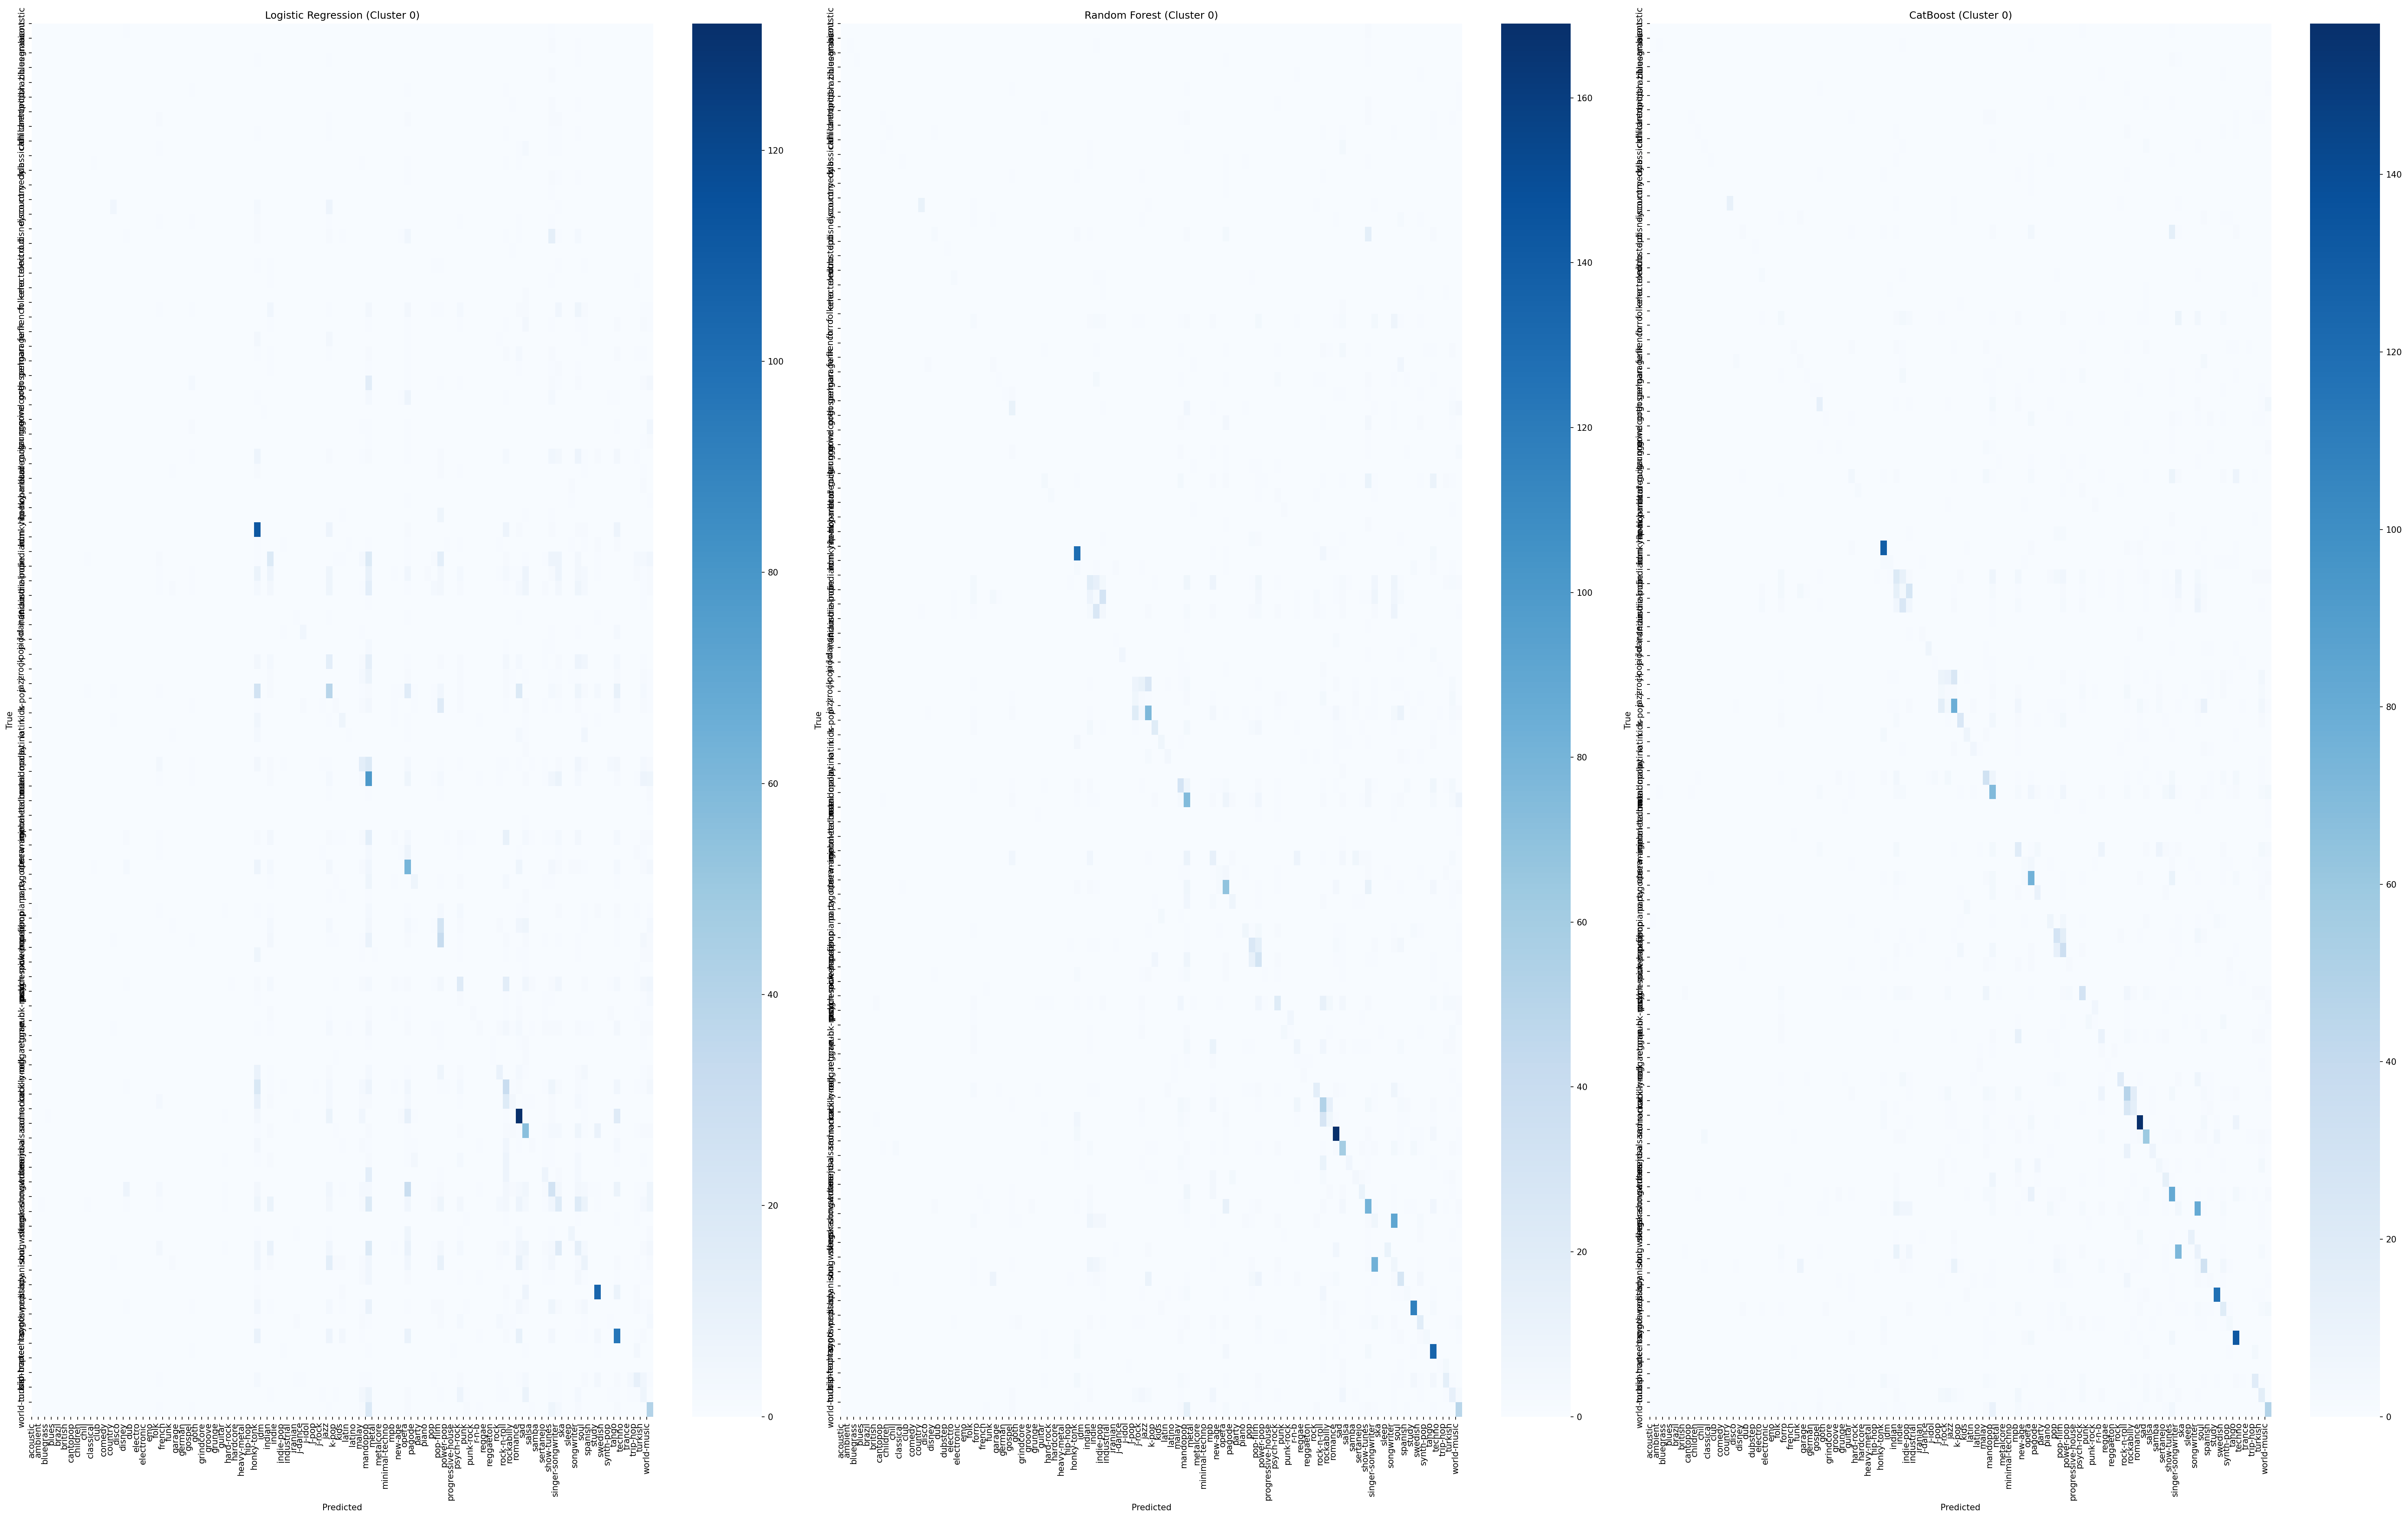

Saved confusion matrix plot to: confusion_matrices\cluster_0_confusion_matrix.png

=== Confusion Matrix - Cluster 1 ===


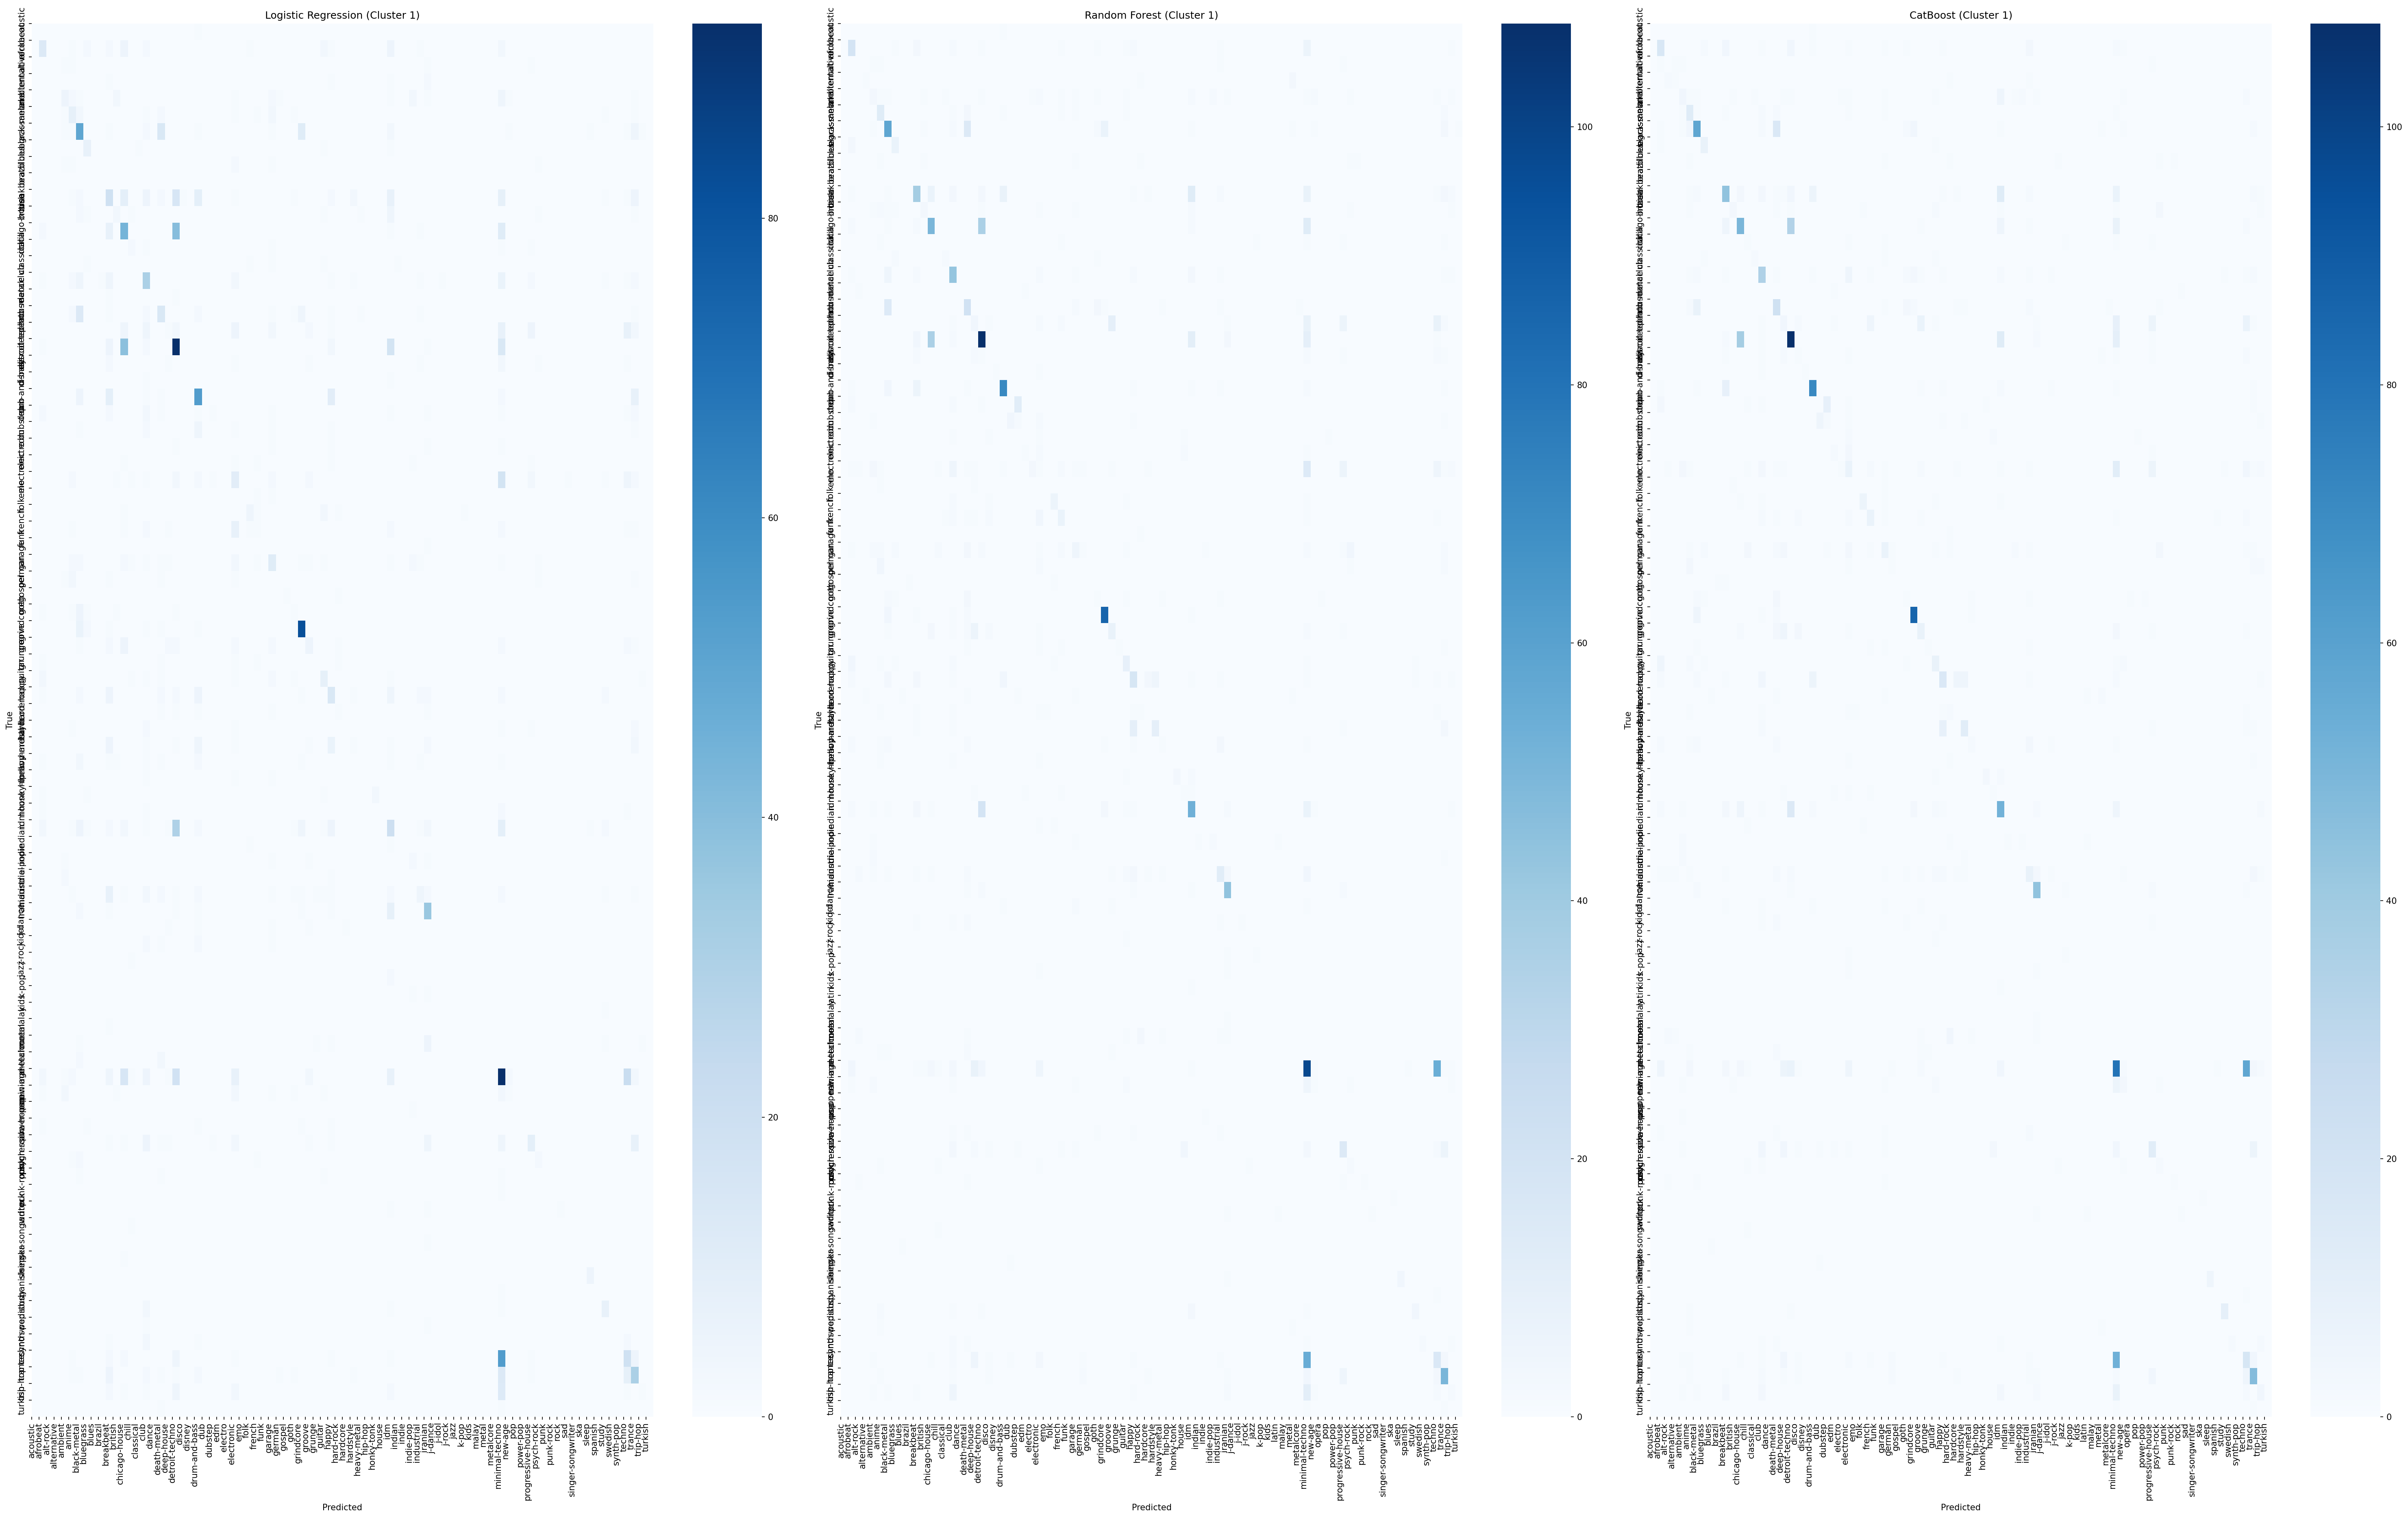

Saved confusion matrix plot to: confusion_matrices\cluster_1_confusion_matrix.png

=== Confusion Matrix - Cluster 2 ===


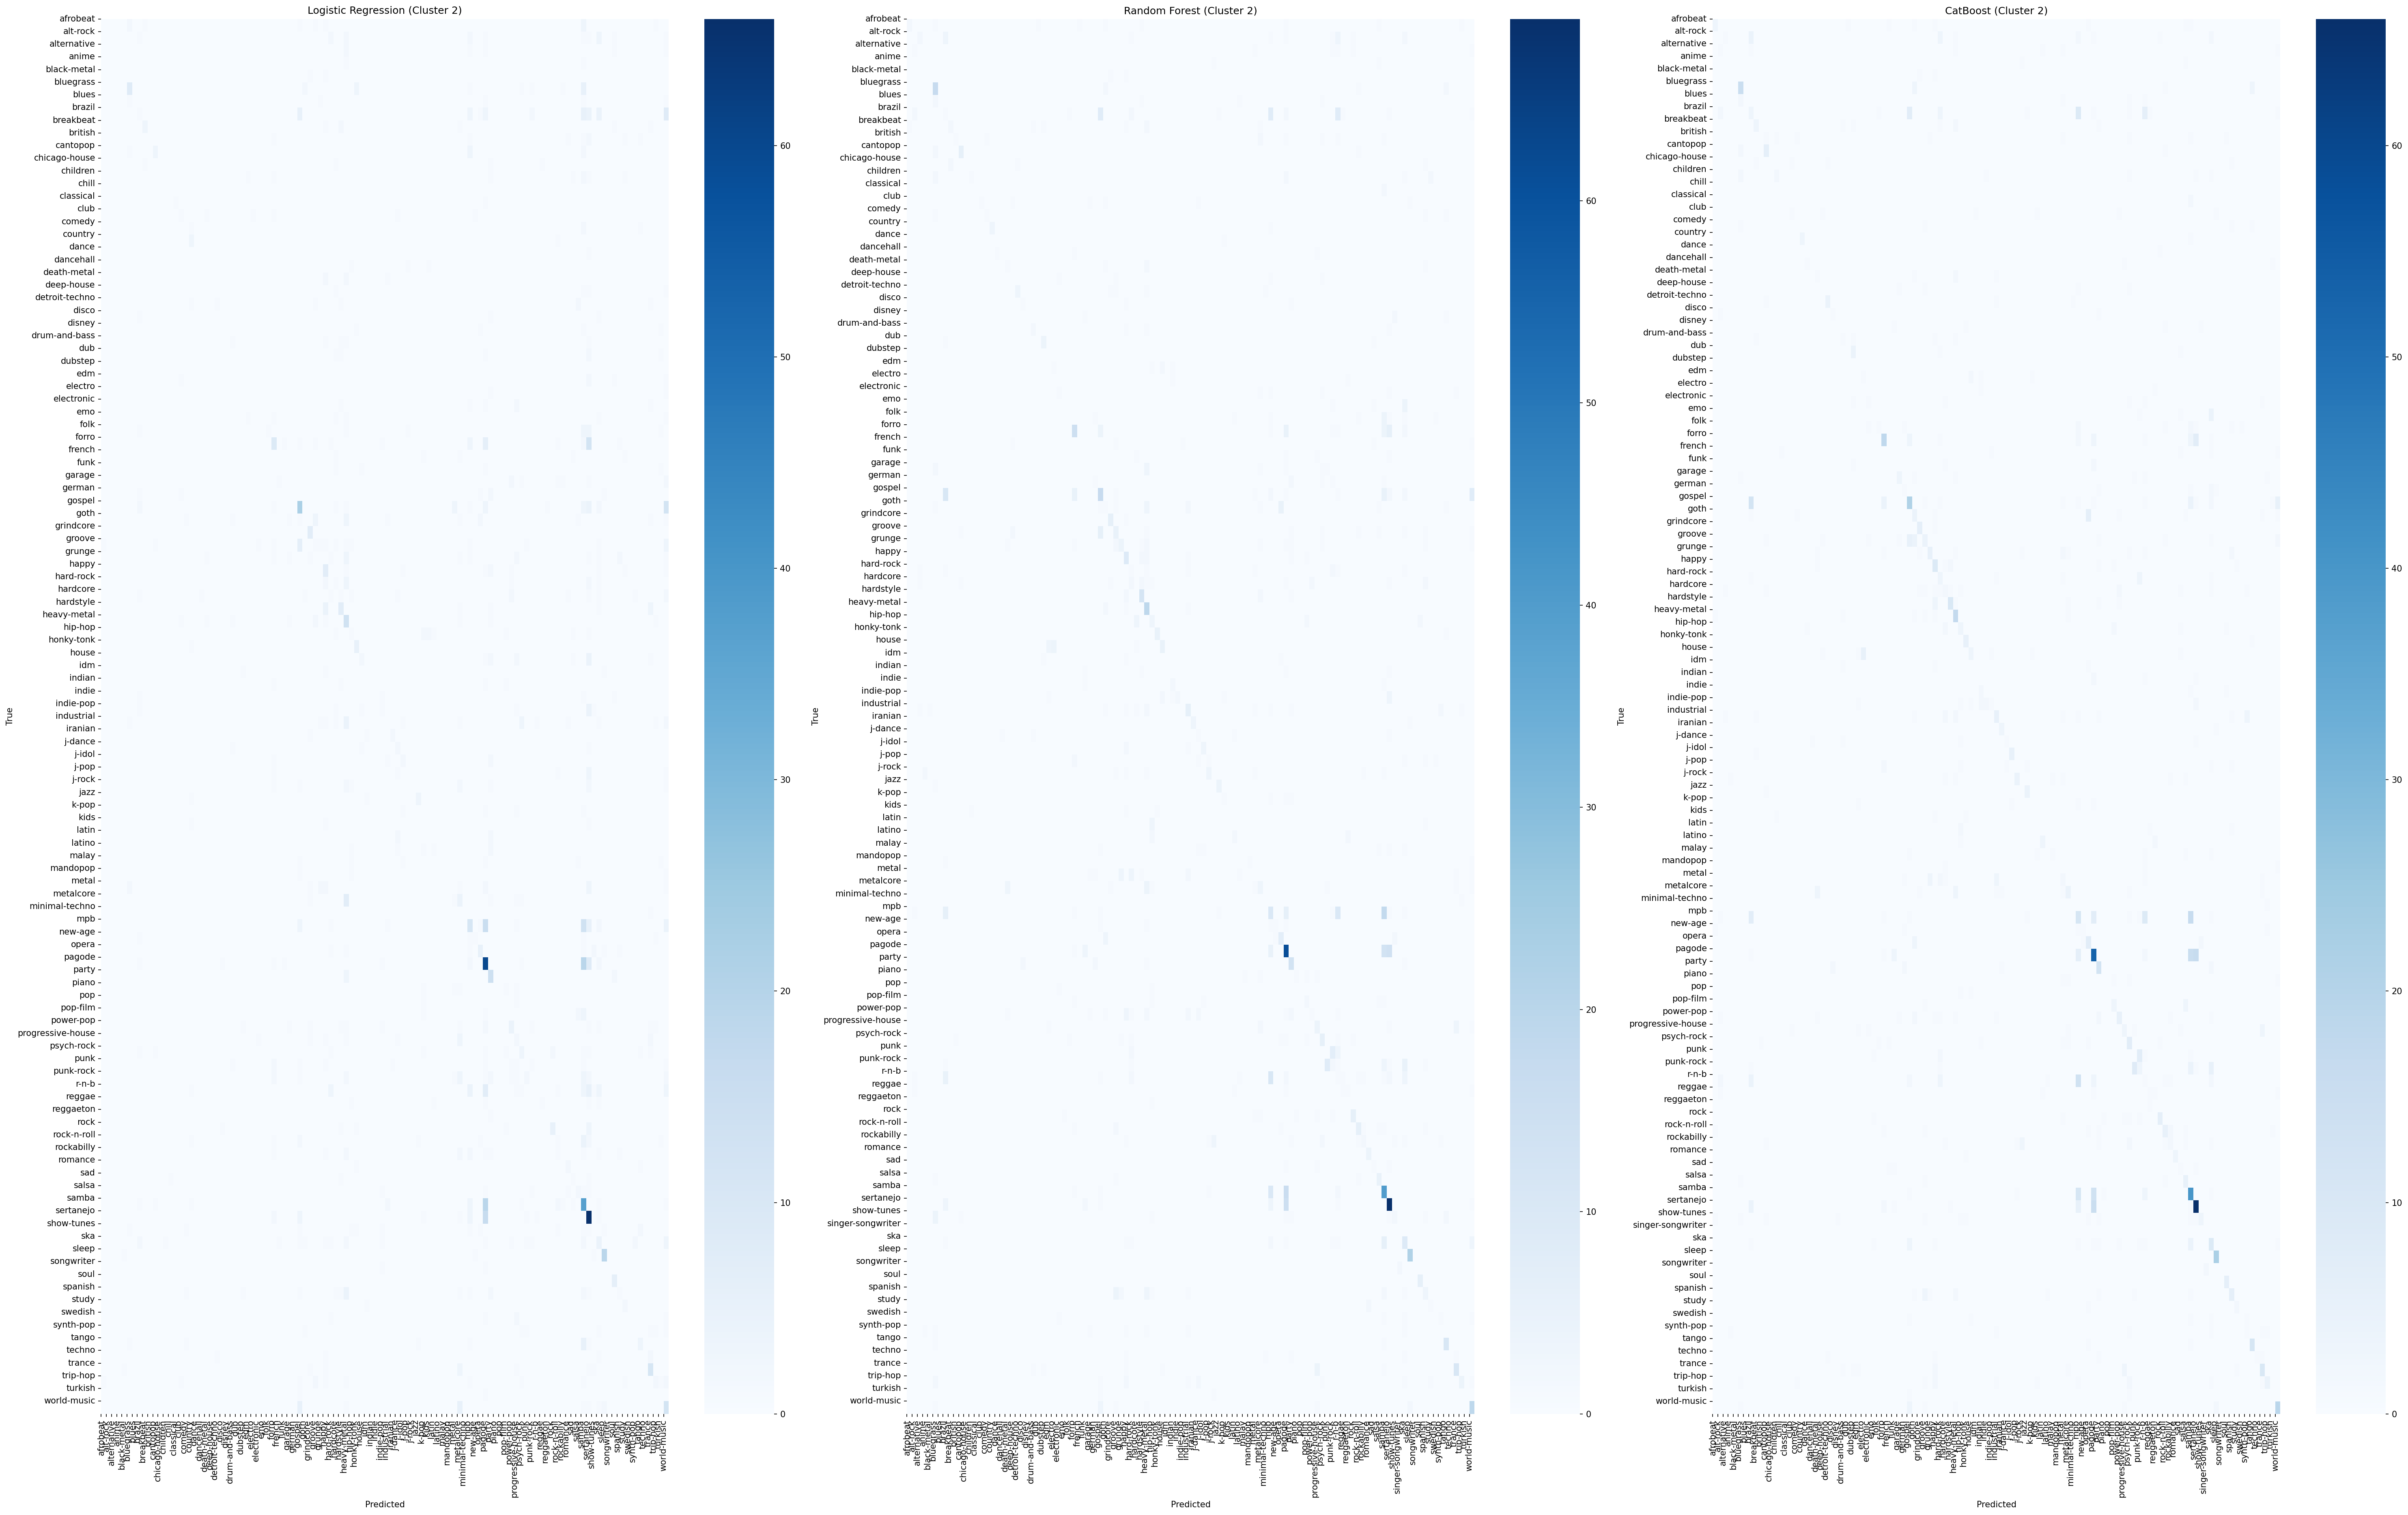

Saved confusion matrix plot to: confusion_matrices\cluster_2_confusion_matrix.png

=== Confusion Matrix - Cluster 3 ===


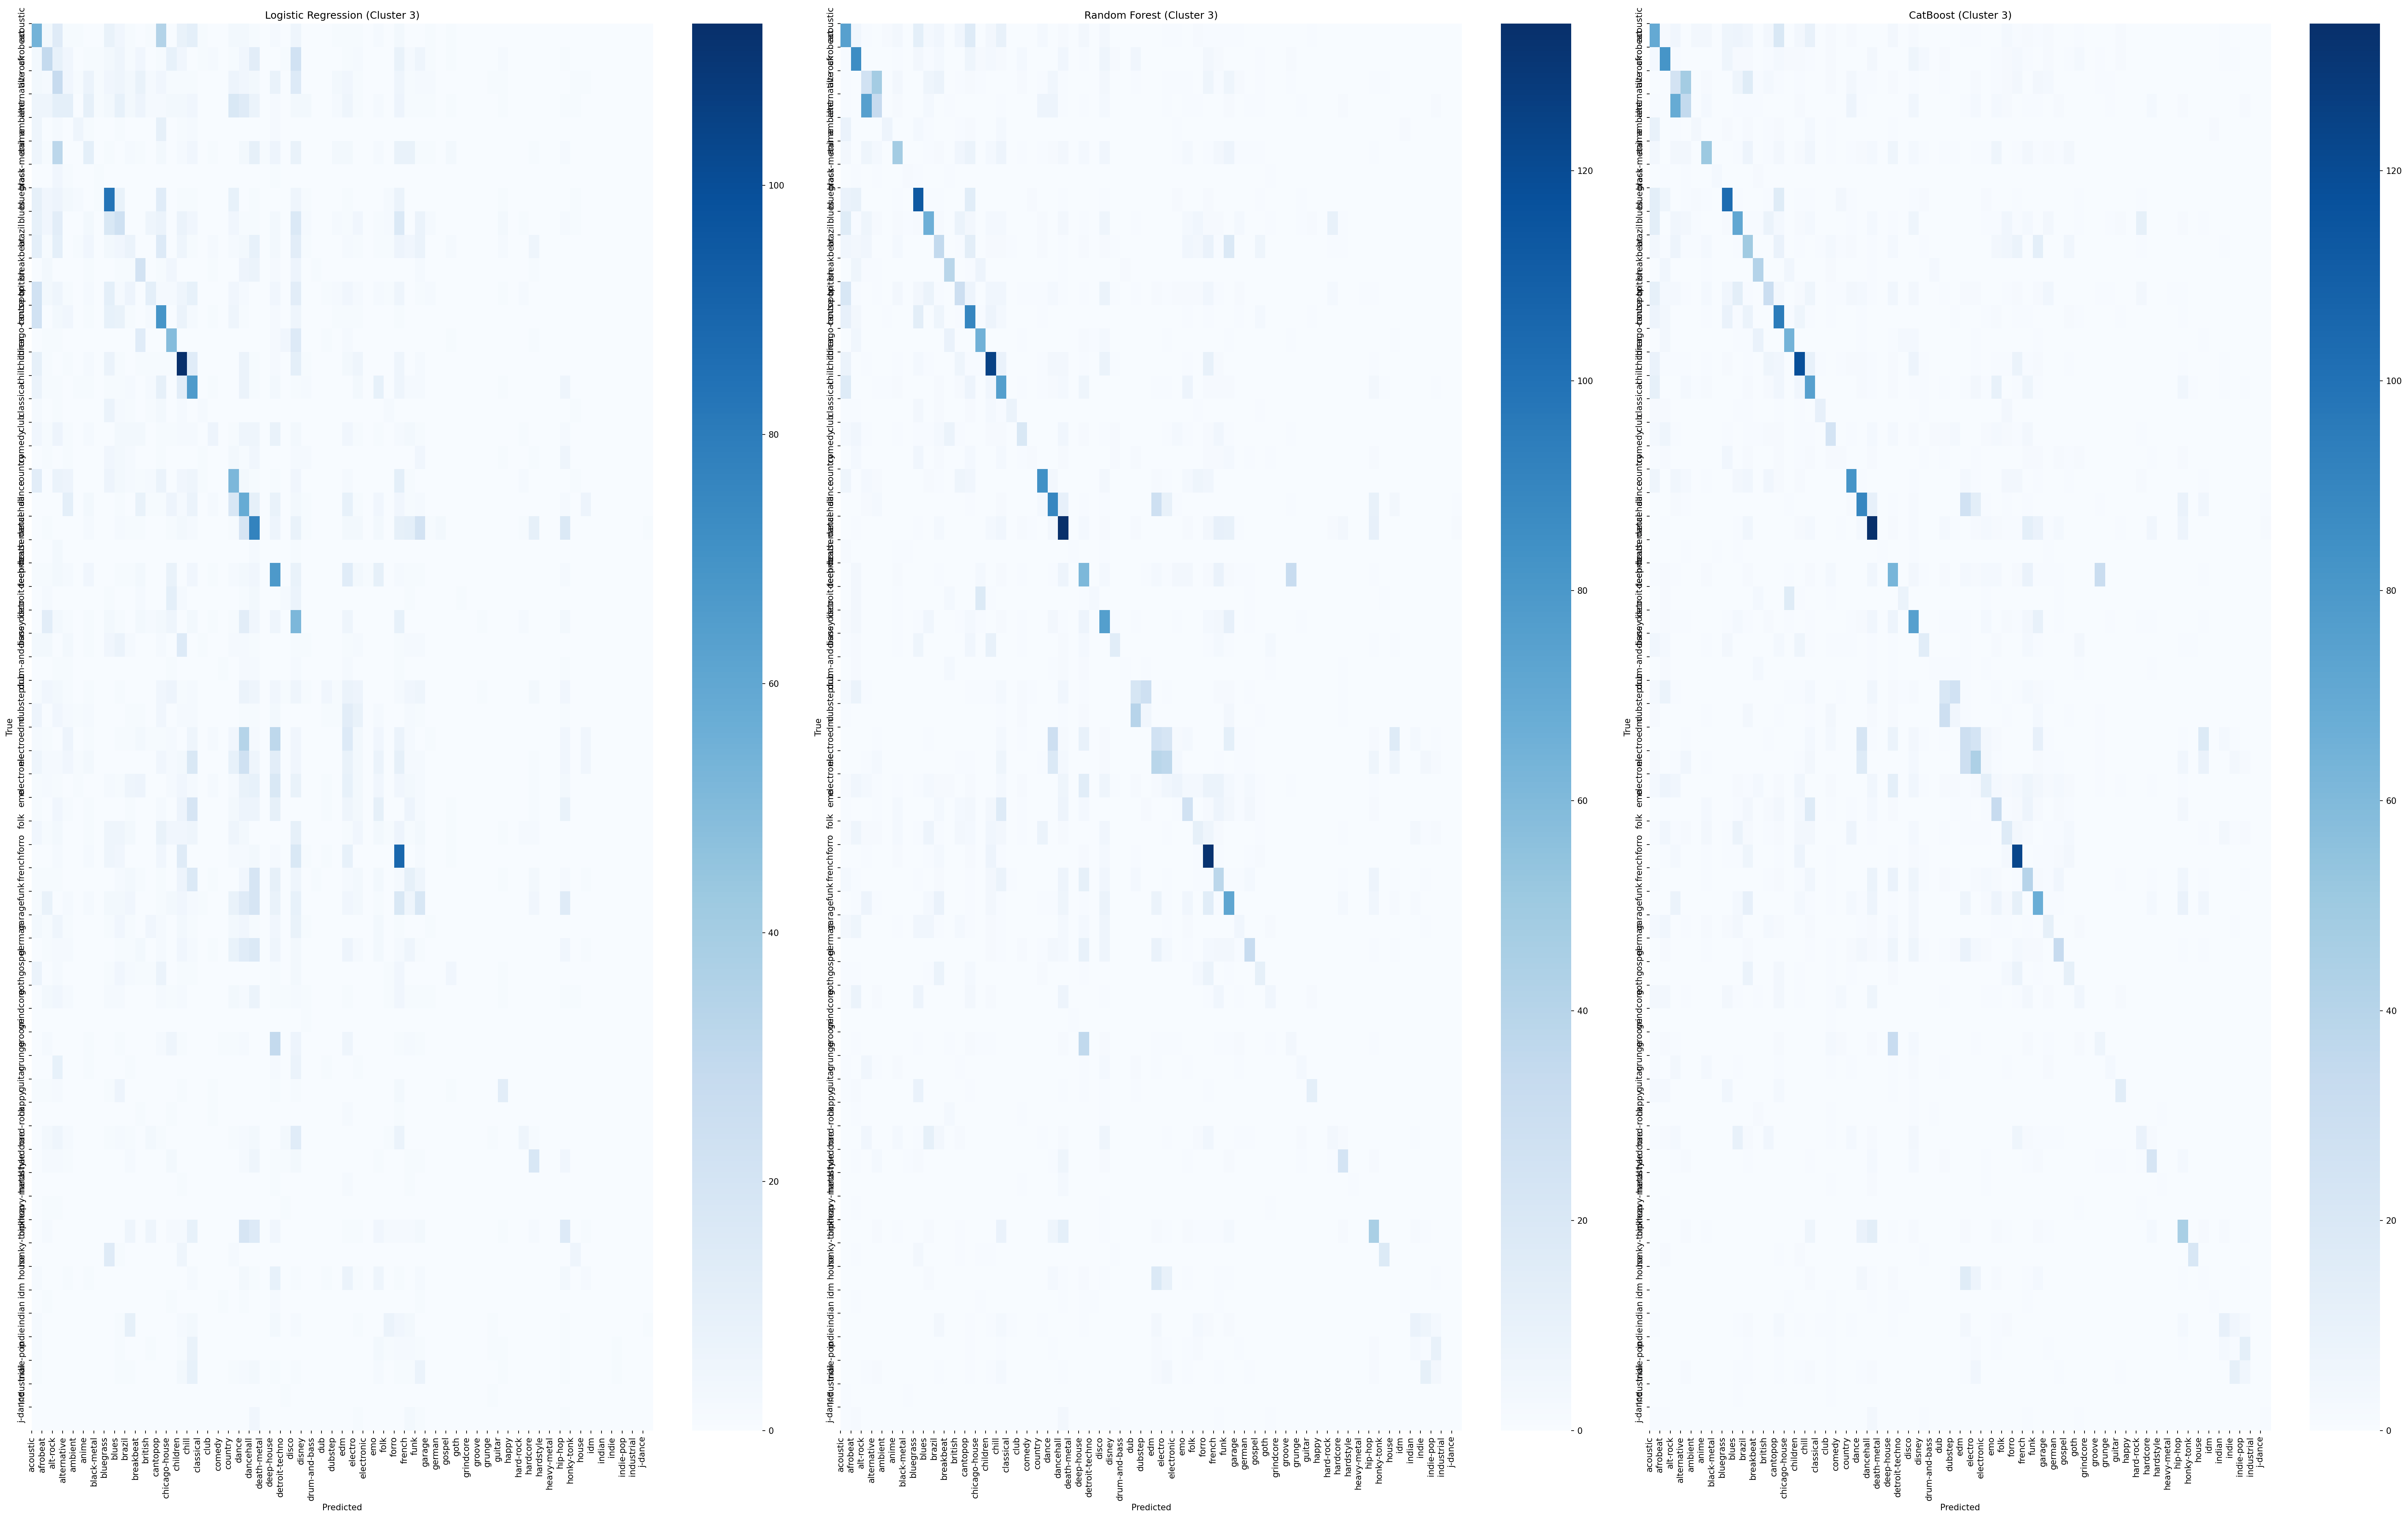

Saved confusion matrix plot to: confusion_matrices\cluster_3_confusion_matrix.png

=== Confusion Matrix - Cluster 4 ===


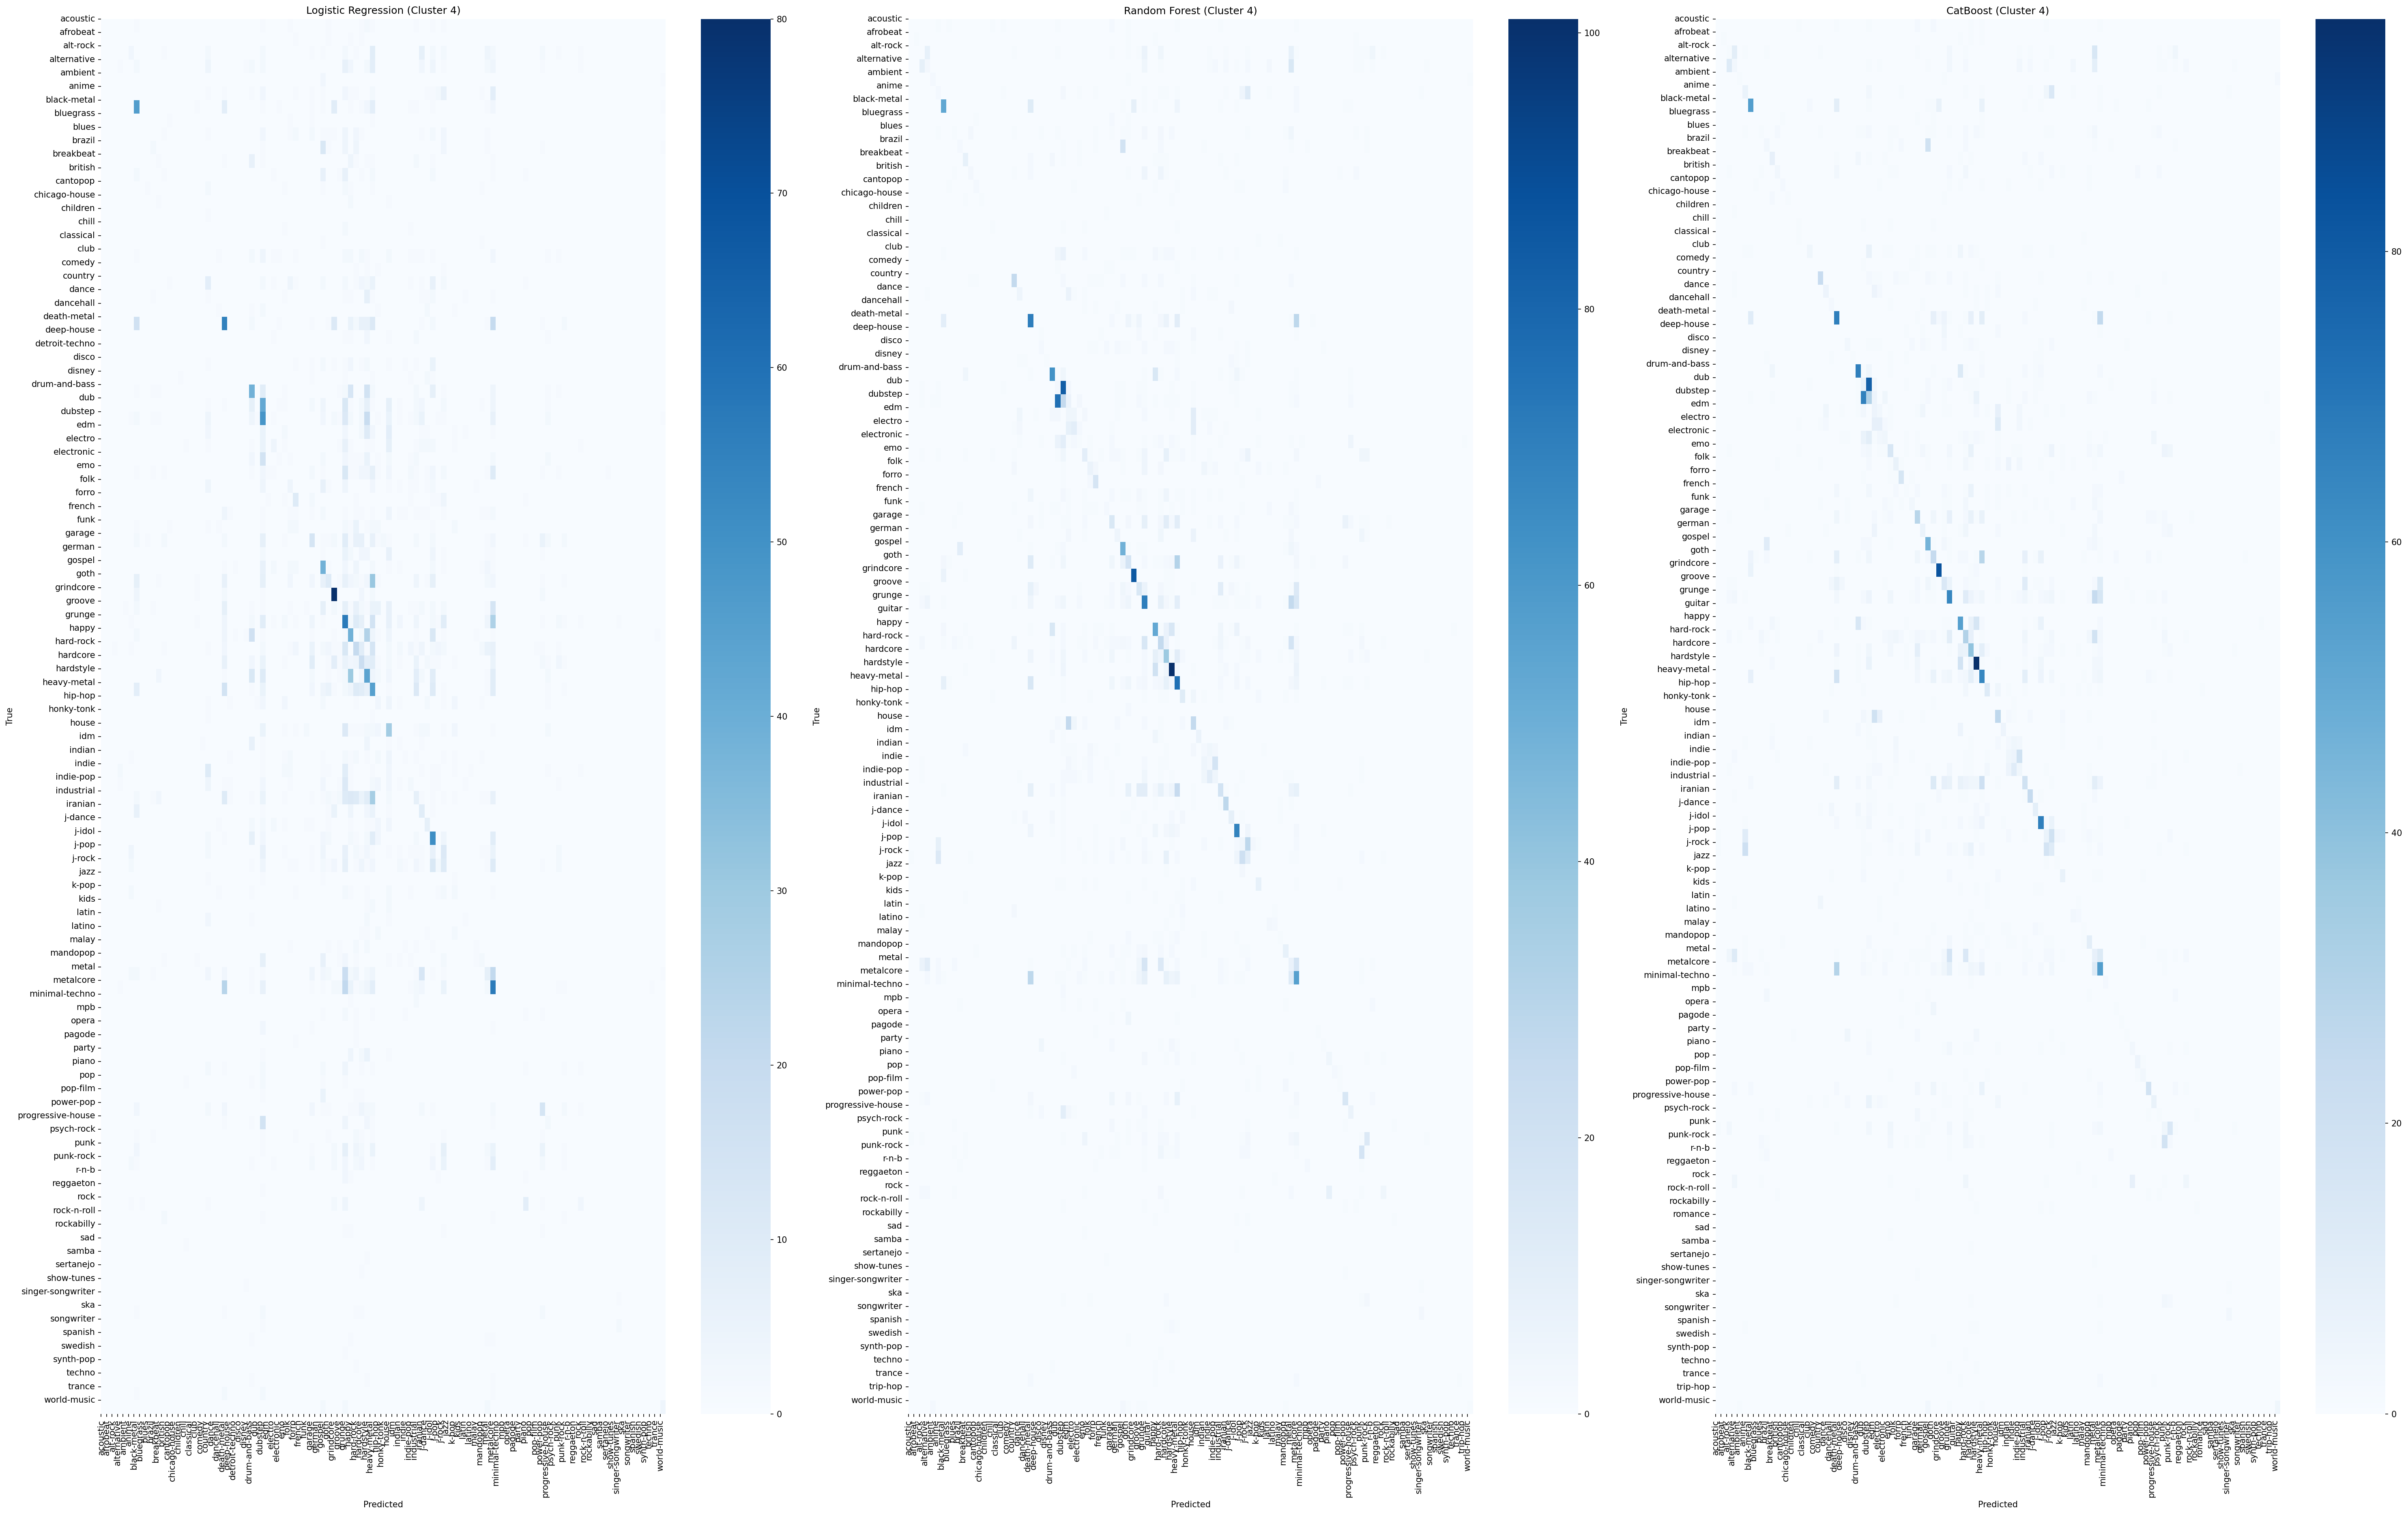

Saved confusion matrix plot to: confusion_matrices\cluster_4_confusion_matrix.png

=== Confusion Matrix - Cluster 5 ===


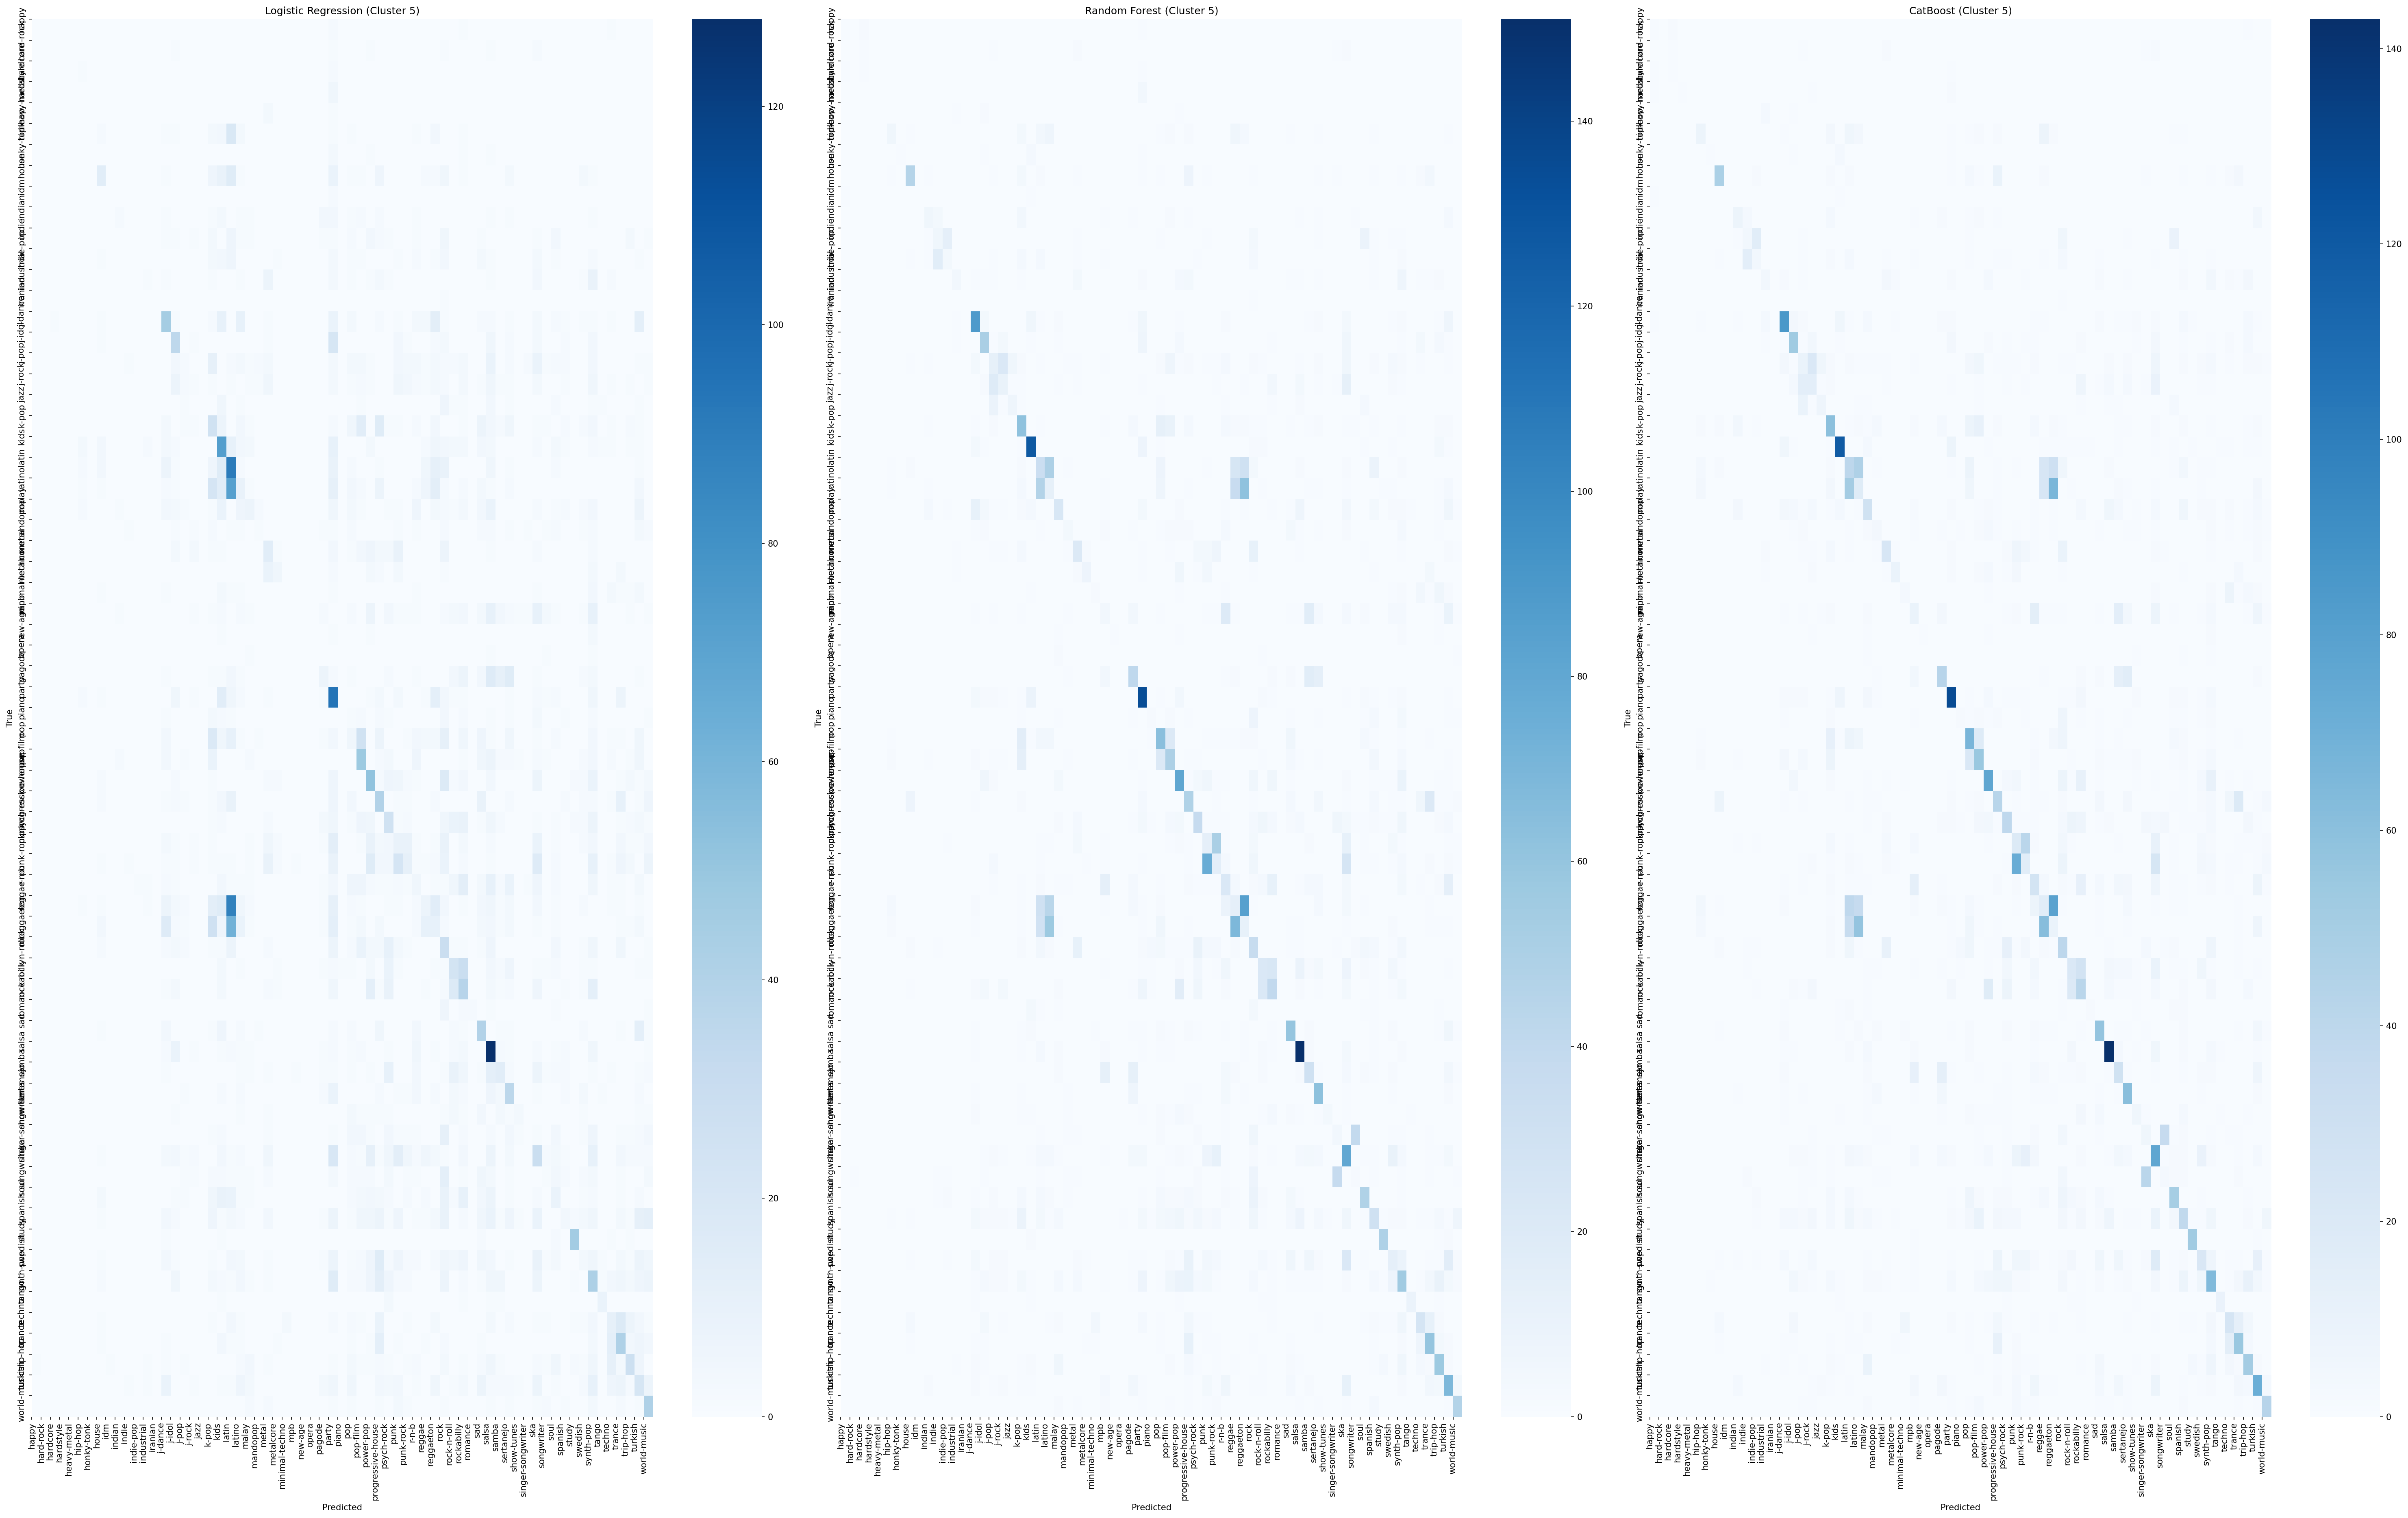

Saved confusion matrix plot to: confusion_matrices\cluster_5_confusion_matrix.png

=== Confusion Matrix - Cluster 6 ===


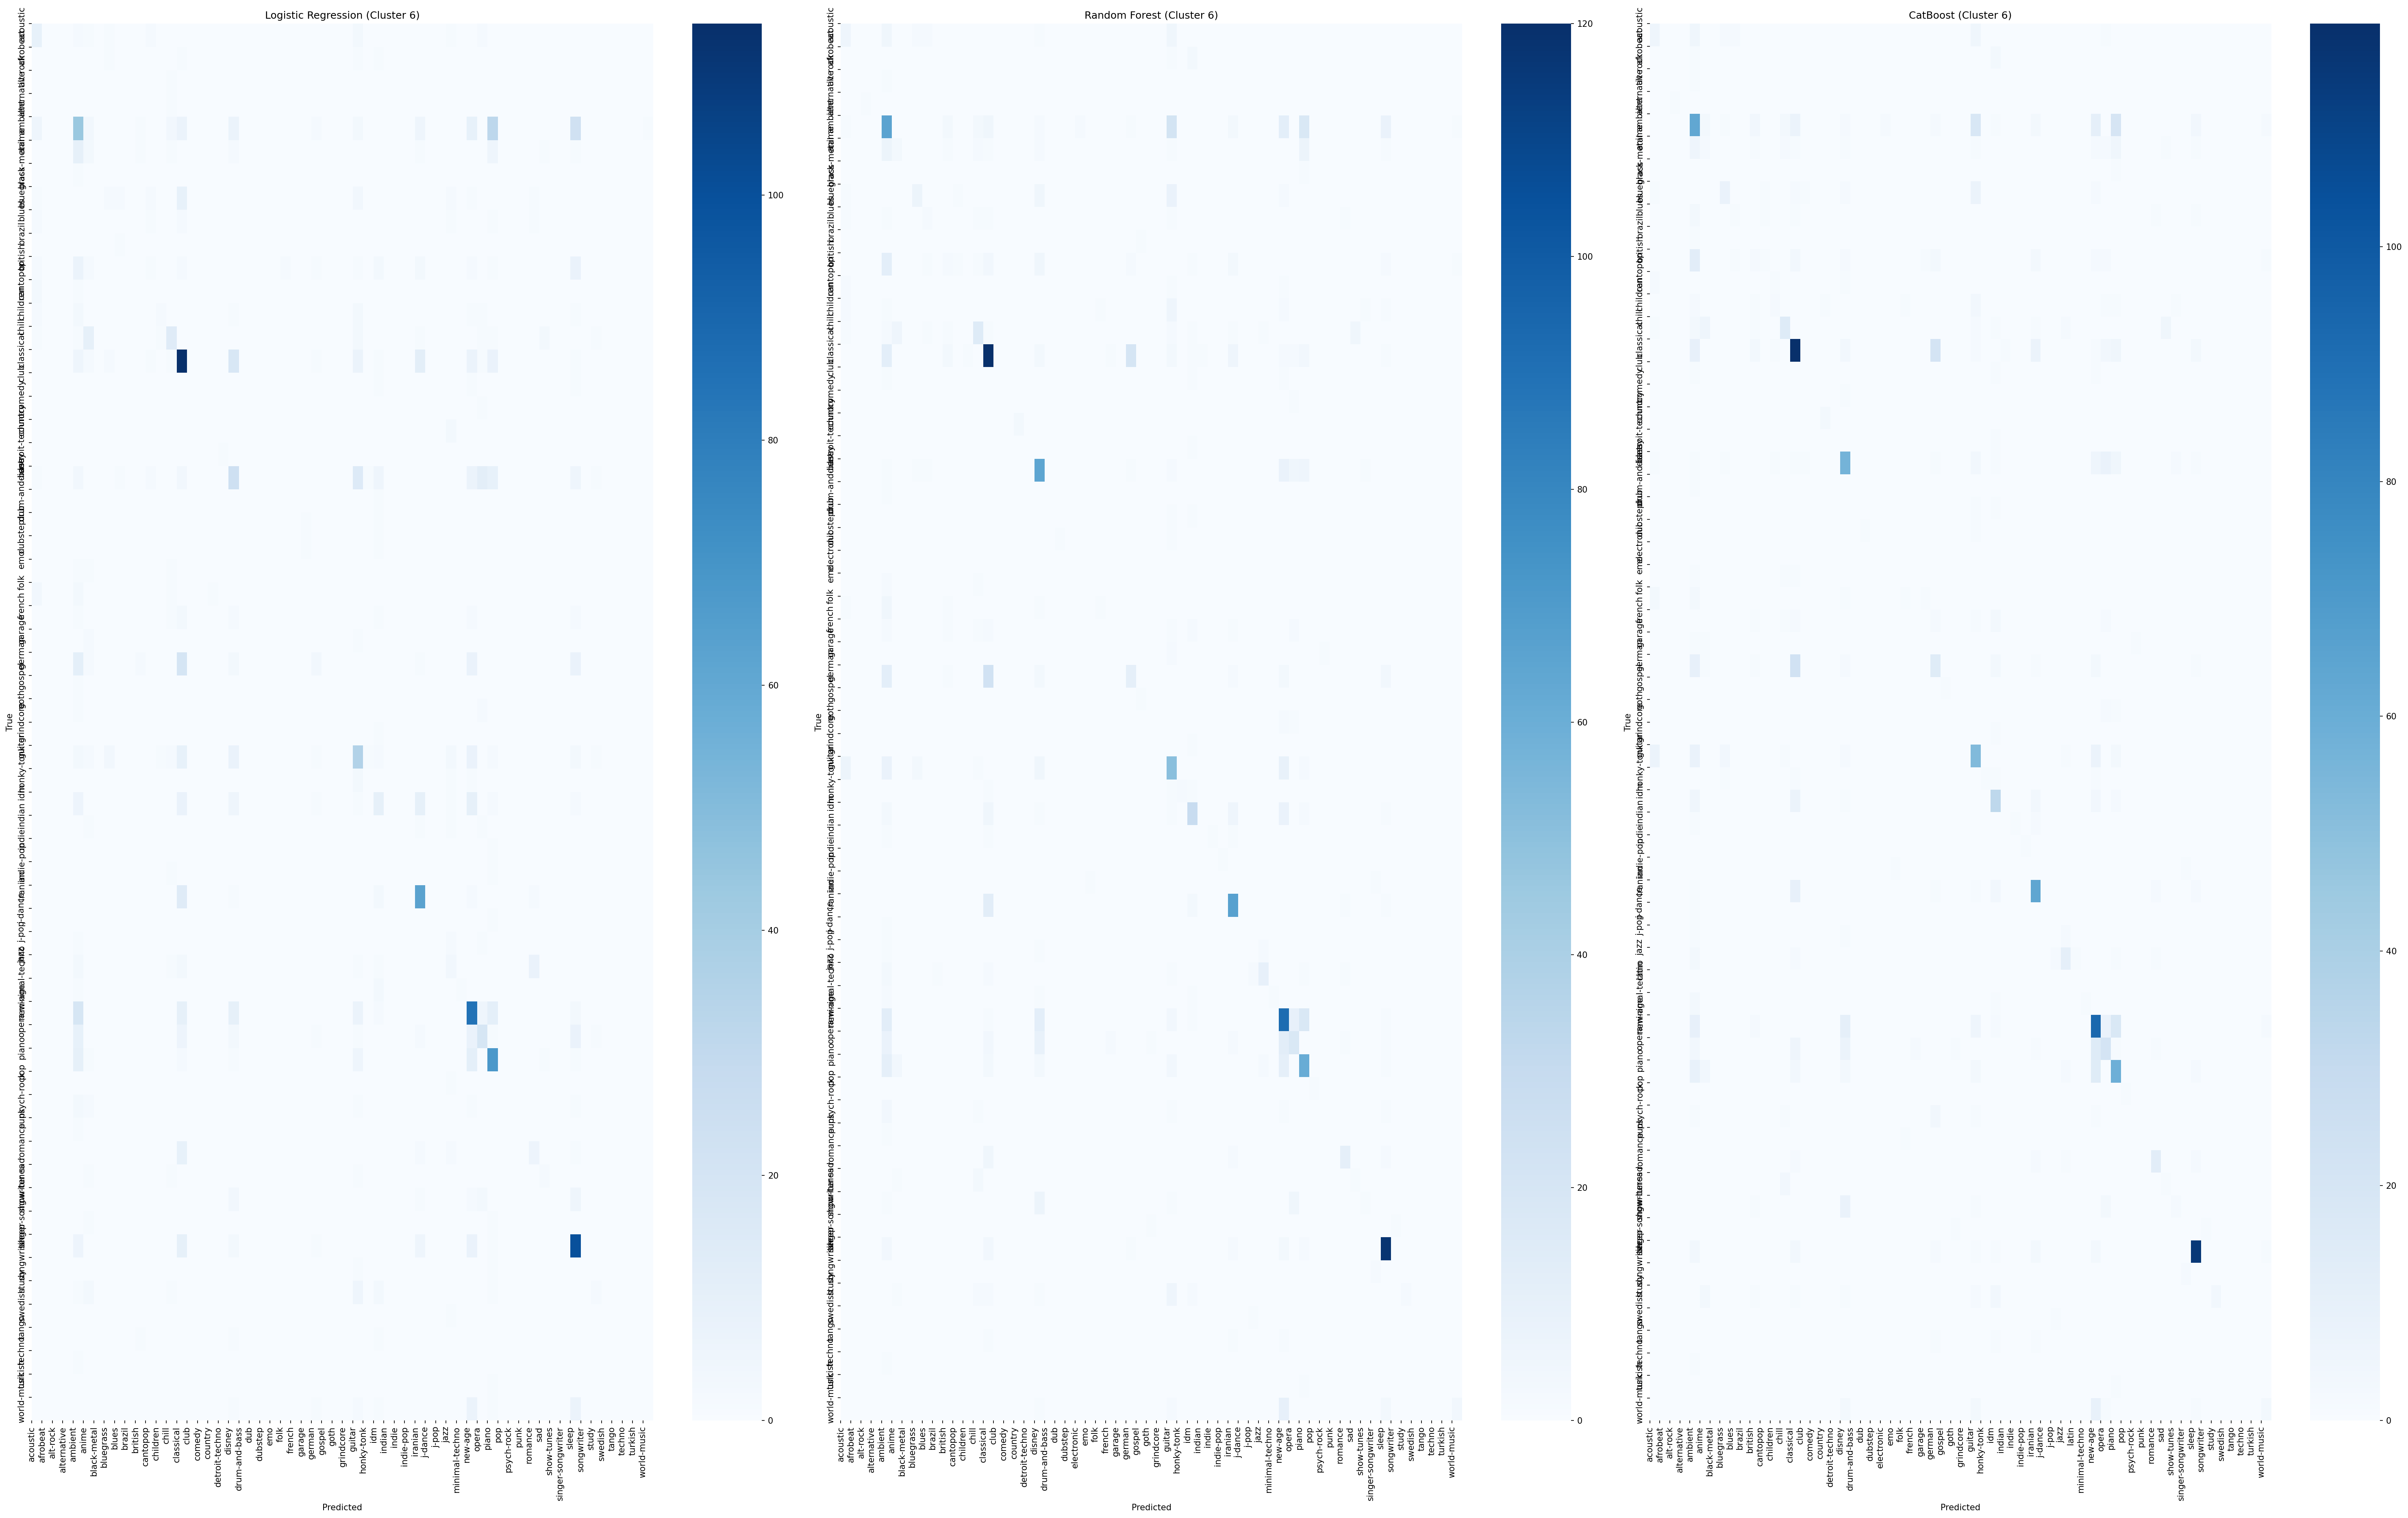

Saved confusion matrix plot to: confusion_matrices\cluster_6_confusion_matrix.png

=== Confusion Matrix - Cluster 7 ===


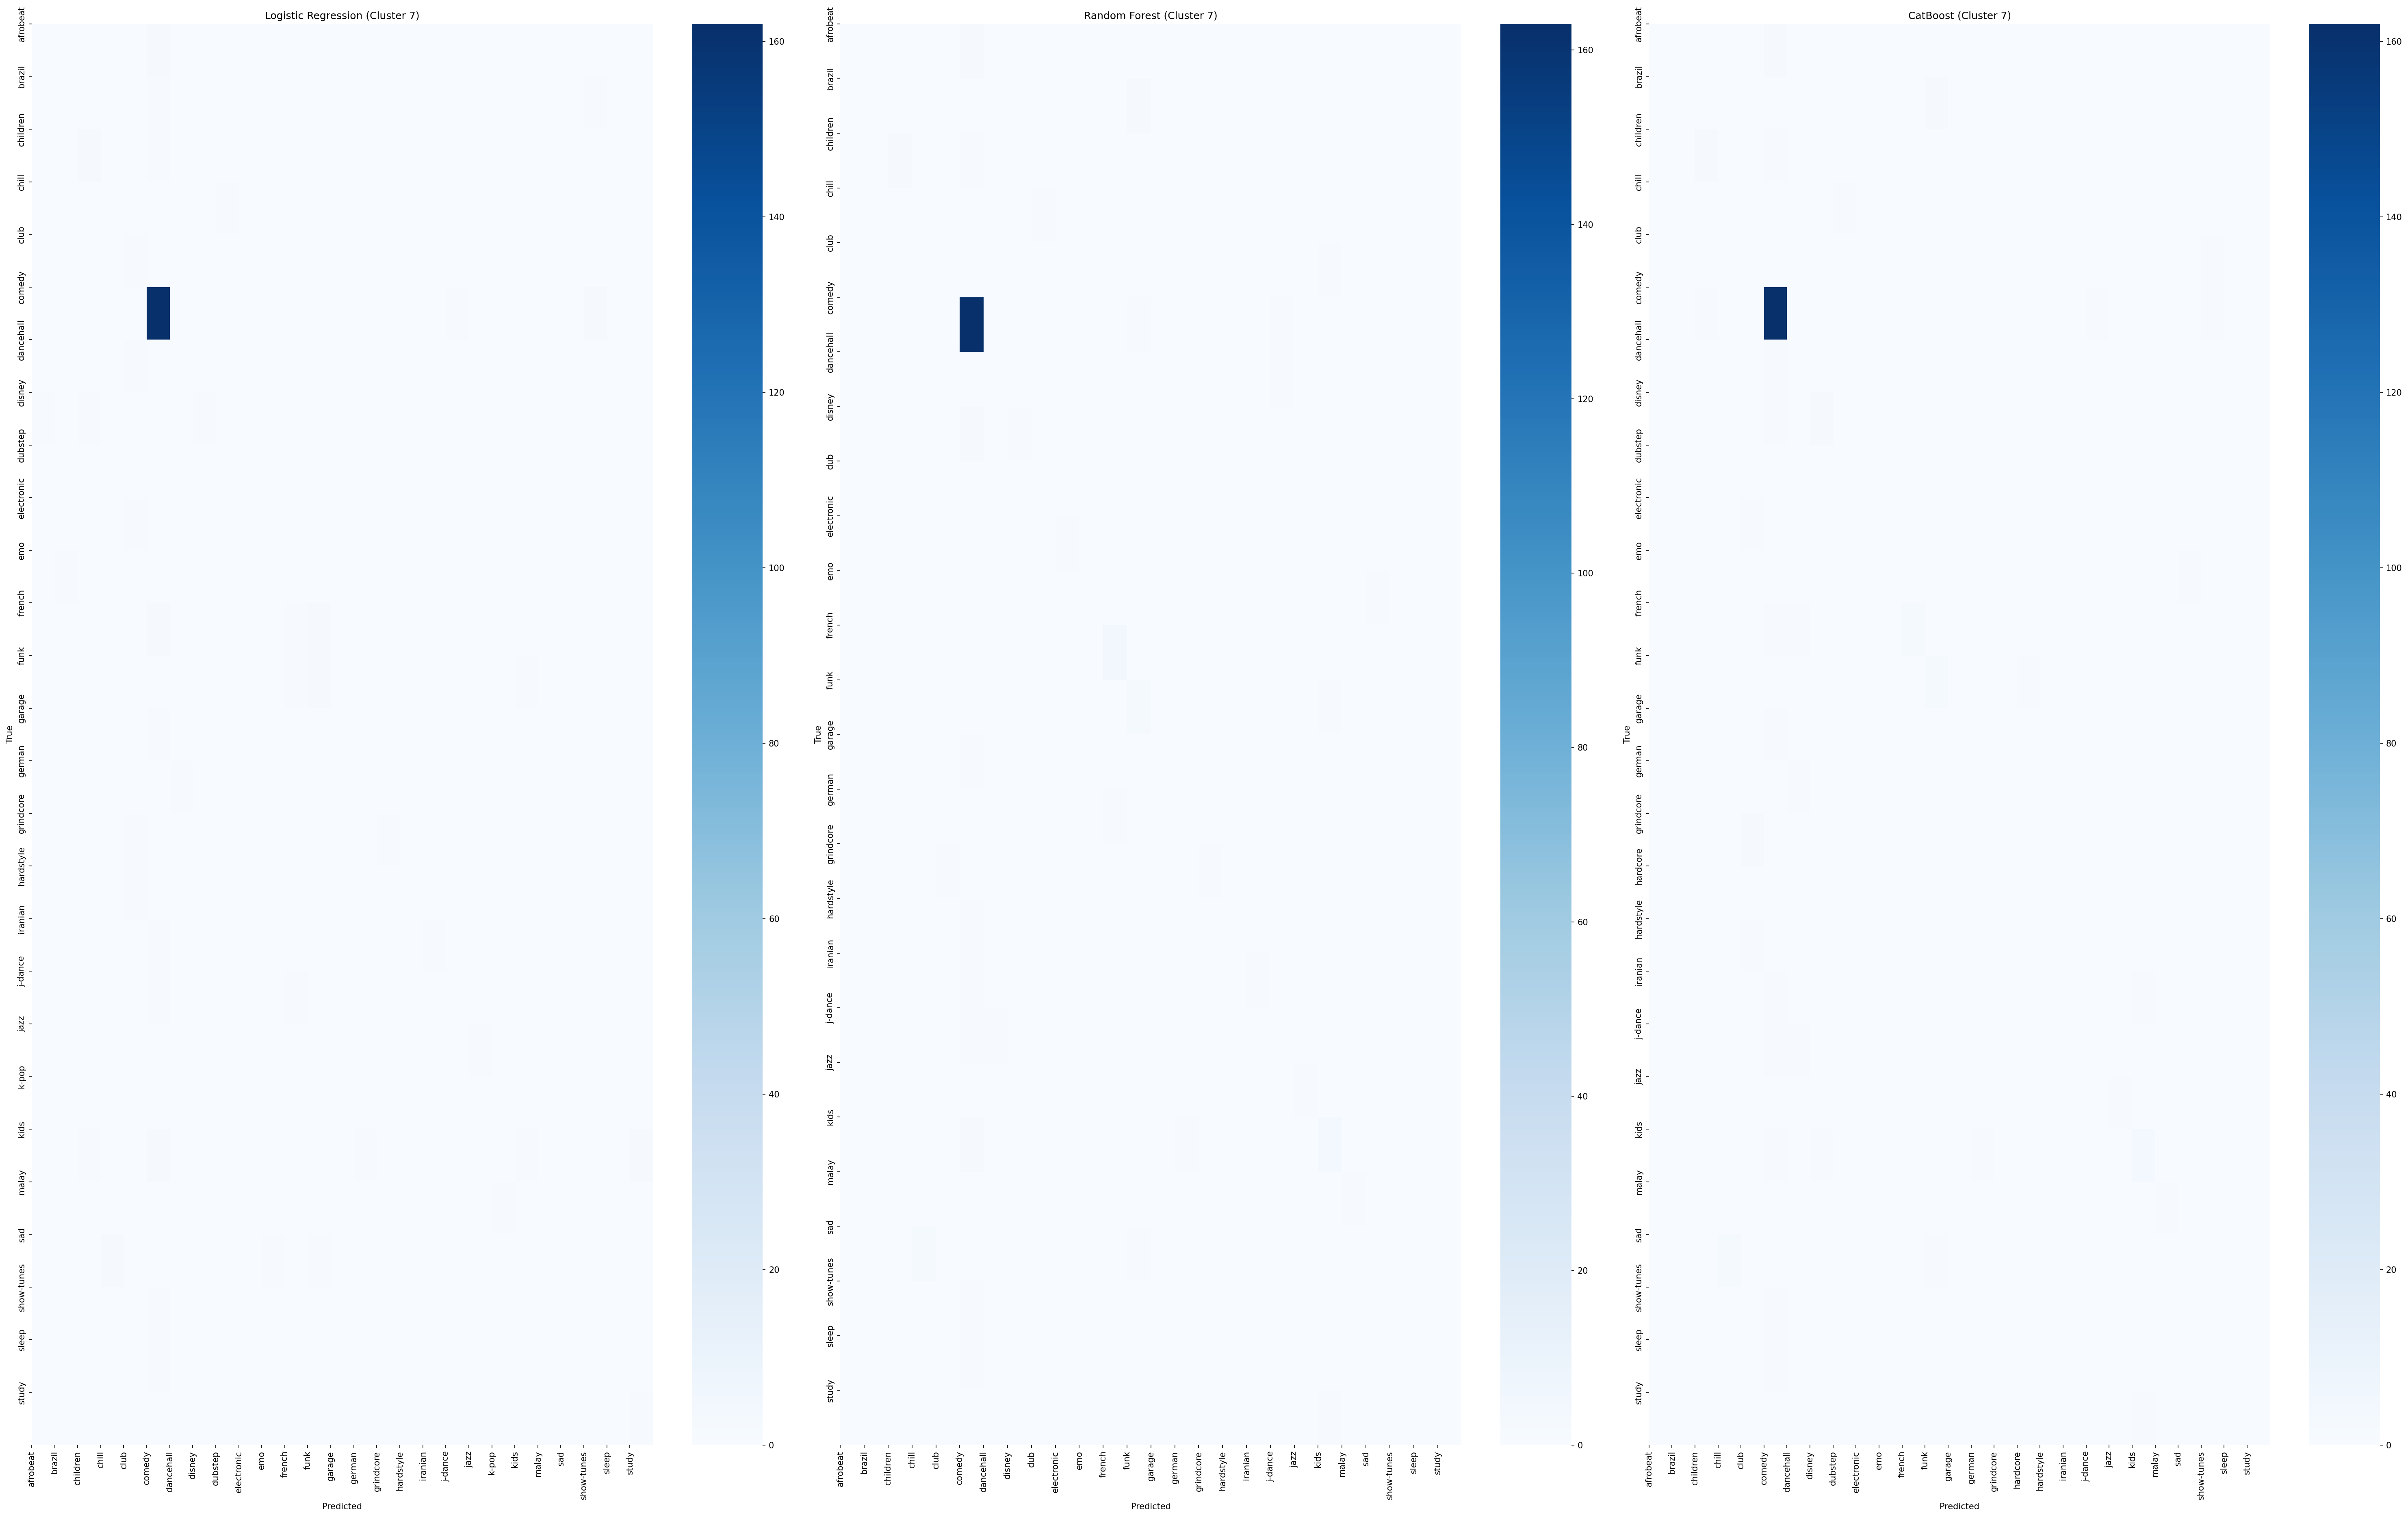

Saved confusion matrix plot to: confusion_matrices\cluster_7_confusion_matrix.png


In [5]:
#Confusion Matrix(for three models)
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

model_infos = {
    'Logistic Regression': {
        'dir': 'saved_models/logistic',
        'model_suffix': '.joblib',
        'loader': joblib.load
    },
    'Random Forest': {
        'dir': 'saved_models/random_forest',
        'model_suffix': '.joblib',
        'loader': joblib.load
    },
    'CatBoost': {
        'dir': 'saved_models/catboost',
        'model_suffix': '.cbm',
        'loader': lambda path: CatBoostClassifier().load_model(path)
    }
}

data_dir = 'cluster_split_data'
output_dir = 'confusion_matrices'
os.makedirs(output_dir, exist_ok=True)


cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_test.csv')
))

for cluster_id in cluster_ids:
    print(f"\n=== Confusion Matrix - Cluster {cluster_id} ===")
    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    test_df = pd.read_csv(test_path)

    if 'genre_label' in test_df.columns:
        test_df['track_genre'] = test_df['genre_label']

    if 'track_genre' not in test_df.columns:
        print("Skipped: 'track_genre' column not found in test set.")
        continue

    y_test = test_df['track_genre'].astype(str) 

    fig, axes = plt.subplots(1, 3, figsize=(40, 25), dpi=150)

    for idx, (model_name, info) in enumerate(model_infos.items()):
        model_dir = info['dir']
        model_suffix = info['model_suffix']
        model_loader = info['loader']

        model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model{model_suffix}')
        scaler_path = os.path.join(model_dir, f'cluster_{cluster_id}_scaler.joblib')

        if not os.path.exists(model_path) or not os.path.exists(scaler_path):
            print(f"[Skipped] {model_name} model or scaler not found.")
            continue

        # Load model and scaler
        try:
            model = model_loader(model_path)
        except Exception as e:
            print(f"[Error] Failed to load {model_name} model: {e}")
            continue

        scaler = joblib.load(scaler_path)

        #Ensure only numeric features used during training are retained
        feature_cols = scaler.feature_names_in_  # Requires sklearn >= 1.0
        X_test = test_df[feature_cols].copy()
        X_test_scaled = scaler.transform(X_test)

        if model_name == 'CatBoost':
            y_pred = model.predict(X_test_scaled).ravel() 
        else:
            y_pred = model.predict(X_test_scaled)

        labels = sorted(set(y_test) | set(y_pred))
        cm = confusion_matrix(y_test, y_pred, labels=labels)

        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{model_name} (Cluster {cluster_id})')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
        axes[idx].set_xticks(ticks=range(len(labels)), labels=labels, rotation=90)
        axes[idx].set_yticks(ticks=range(len(labels)), labels=labels)

    plt.tight_layout()
    plt.show()

    save_path = os.path.join(output_dir, f'cluster_{cluster_id}_confusion_matrix.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print(f"Saved confusion matrix plot to: {save_path}")



=== Plotting ROC Curve for Cluster 0 ===


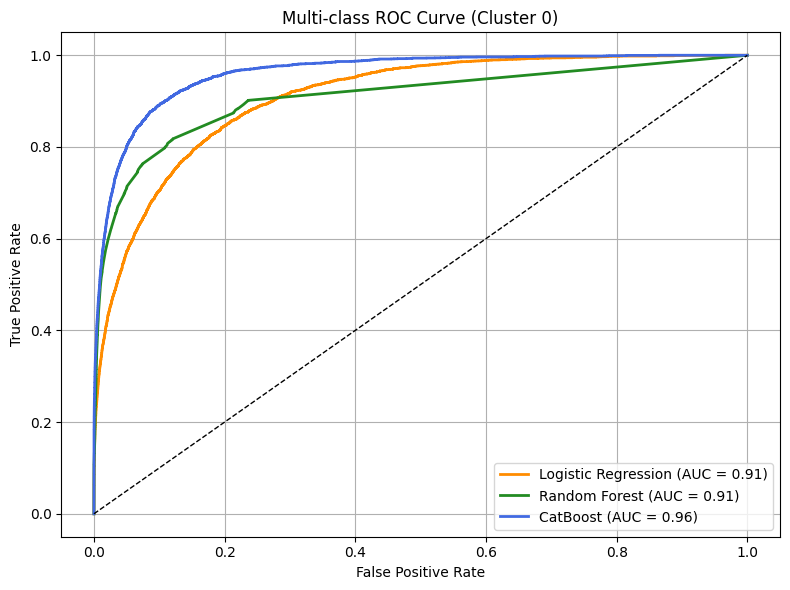


=== Plotting ROC Curve for Cluster 1 ===


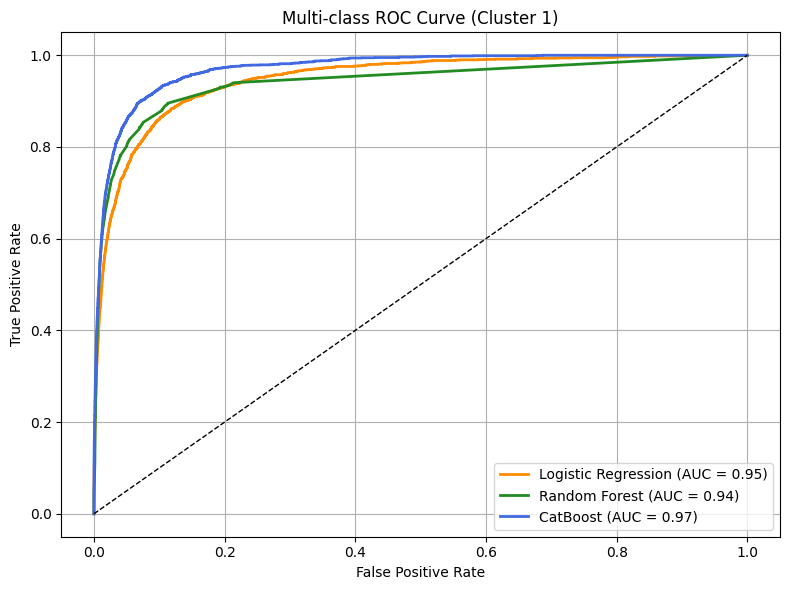


=== Plotting ROC Curve for Cluster 2 ===


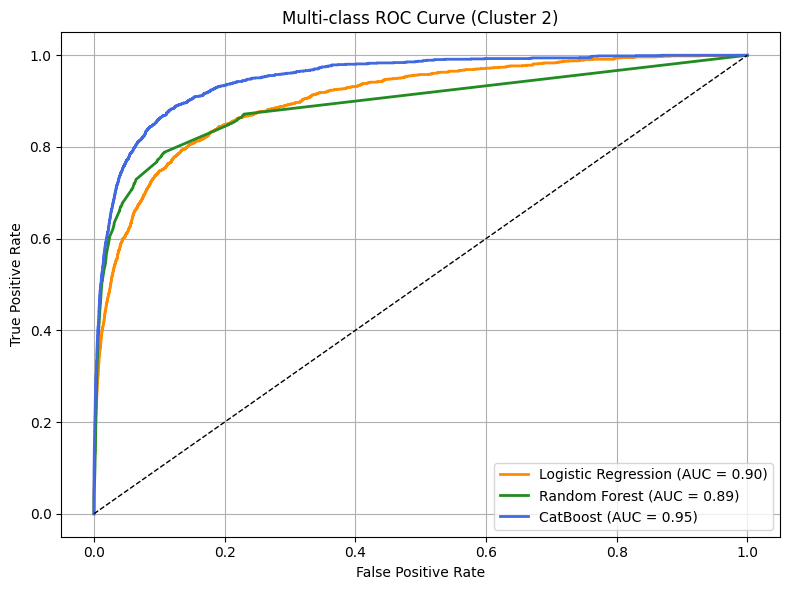


=== Plotting ROC Curve for Cluster 3 ===


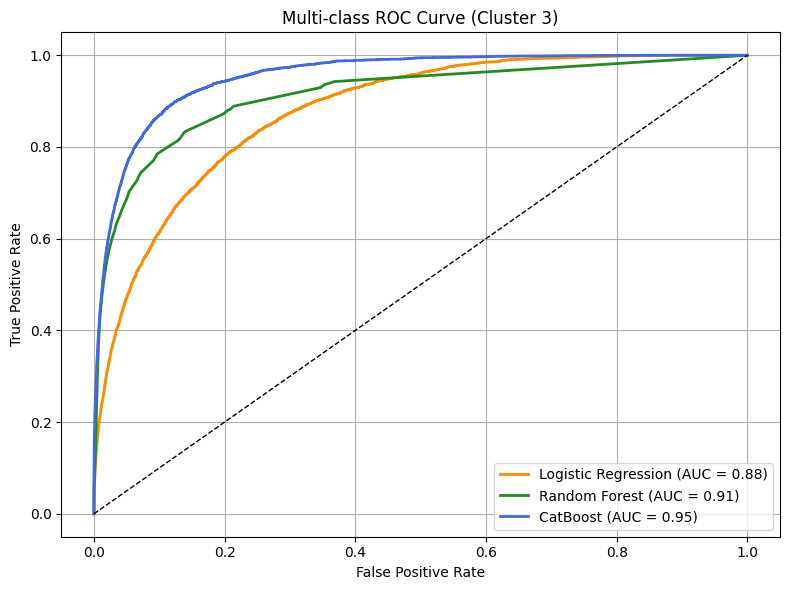


=== Plotting ROC Curve for Cluster 4 ===


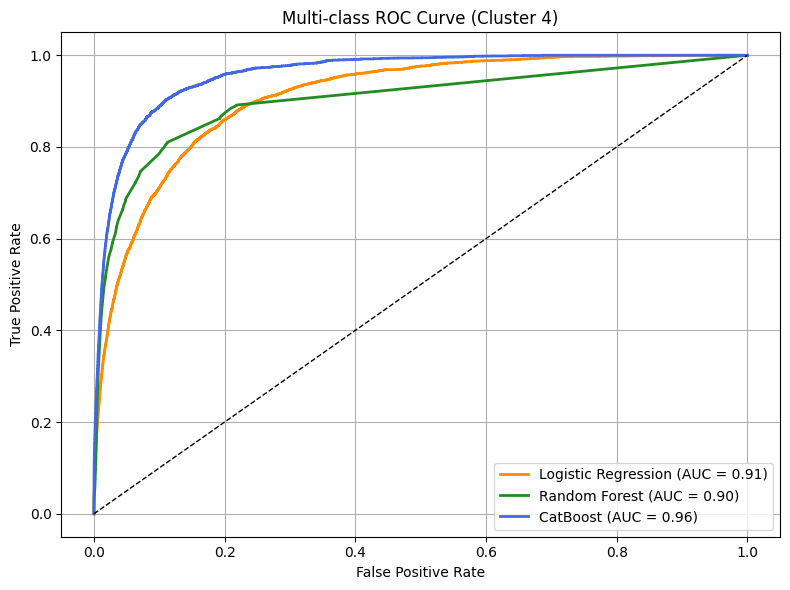


=== Plotting ROC Curve for Cluster 5 ===


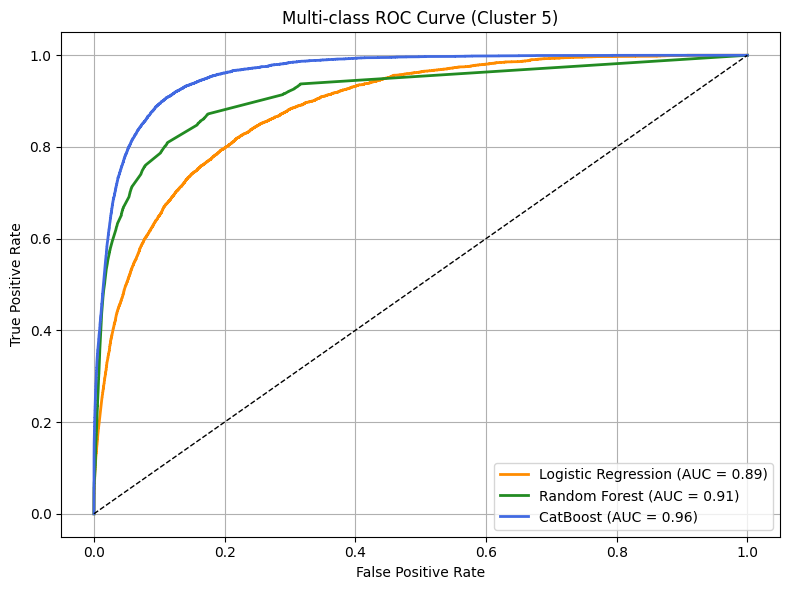


=== Plotting ROC Curve for Cluster 6 ===


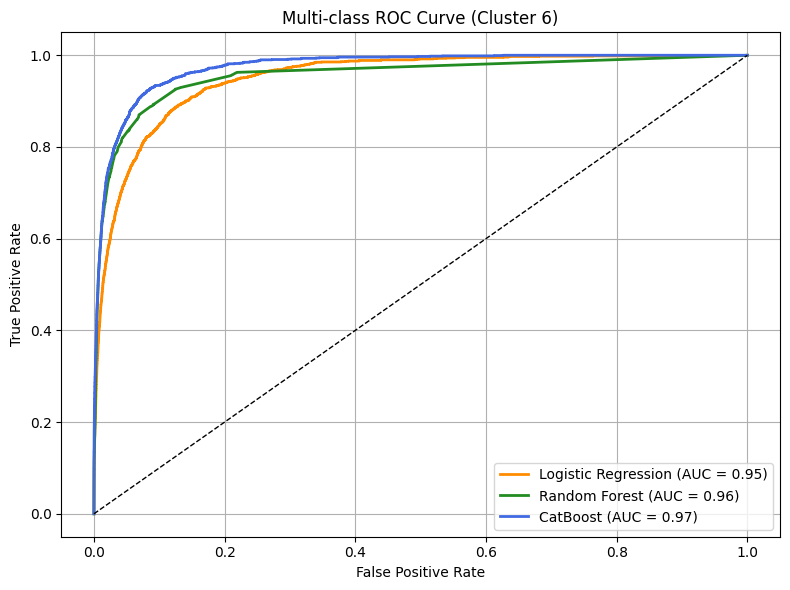


=== Plotting ROC Curve for Cluster 7 ===


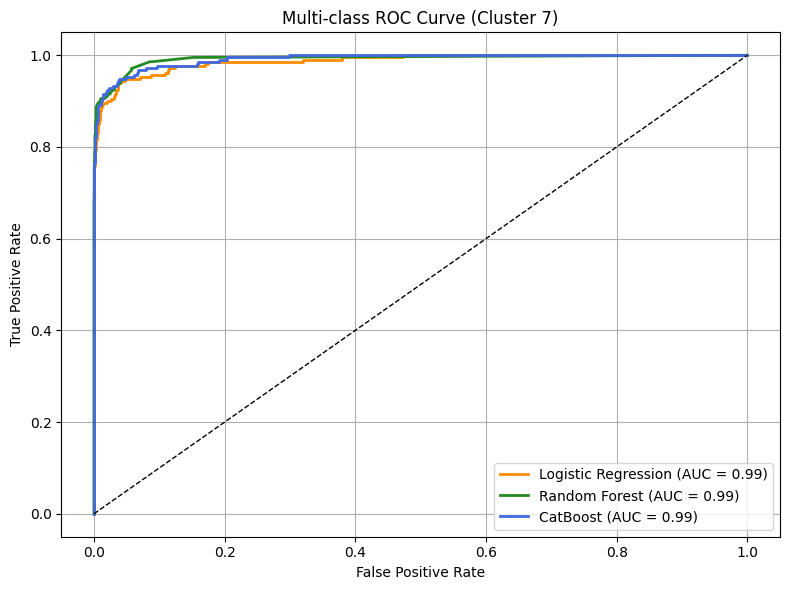

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
from joblib import load
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

data_dir = 'cluster_split_data'
class_dir = 'saved_models/class_names'
model_dirs = {
    'Logistic Regression': 'saved_models/logistic',
    'Random Forest': 'saved_models/random_forest',
    'CatBoost': 'saved_models/catboost'
}
class_file_prefix = {
    'Logistic Regression': 'logistic_cluster',
    'Random Forest': 'random_forest_cluster',
    'CatBoost': 'catboost_cluster'
}

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_test.csv')
))

for cluster_id in cluster_ids:
    print(f"\n=== Plotting ROC Curve for Cluster {cluster_id} ===")
    
    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    test_df = pd.read_csv(test_path)

    if 'genre_label' in test_df.columns:
        test_df['track_genre'] = test_df['genre_label']

    if test_df['track_genre'].nunique() < 2:
        print("Skipped: Less than 2 classes in test set.")
        continue

    X_test = test_df.select_dtypes(include='number').drop(columns=['Unnamed: 0', 'track_genre_encoded', 'cluster'], errors='ignore')
    y_test = test_df['track_genre'].astype(str)

    plt.figure(figsize=(8, 6))
    colors = ['darkorange', 'forestgreen', 'royalblue']

    for i, (model_name, model_dir) in enumerate(model_dirs.items()):
        #Load class names
        class_path = os.path.join(class_dir, f"{class_file_prefix[model_name]}_{cluster_id}_classes.txt")
        if not os.path.exists(class_path):
            print(f"Skipped {model_name}: class name file not found.")
            continue
        with open(class_path, 'r', encoding='utf-8') as f:
            class_names = [line.strip() for line in f if line.strip()]

        if len(class_names) < 2:
            print(f"Skipped {model_name}: less than 2 classes.")
            continue

        y_test_bin = label_binarize(y_test, classes=class_names)
        n_classes = y_test_bin.shape[1]

        #Load scaler
        scaler_path = os.path.join(model_dir, f'cluster_{cluster_id}_scaler.joblib')
        if not os.path.exists(scaler_path):
            print(f"Skipped {model_name}: scaler not found.")
            continue
        scaler = load(scaler_path)
        X_test_scaled = scaler.transform(X_test)

        #Load model
        model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.joblib' if model_name != 'CatBoost' else f'cluster_{cluster_id}_model.cbm')
        if not os.path.exists(model_path):
            print(f"Skipped {model_name}: model not found.")
            continue

        if model_name == 'CatBoost':
            model = CatBoostClassifier()
            model.load_model(model_path)
            y_score = model.predict_proba(X_test_scaled)
        else:
            model = load(model_path)
            y_score = model.predict_proba(X_test_scaled)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), np.array(y_score).ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f"Multi-class ROC Curve (Cluster {cluster_id})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save figure
    plt.savefig(f'cluster_{cluster_id}_roc_comparison.png')
    plt.close()

In [8]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'cluster_split_data'
model_dir = 'saved_models/logistic'
scaler_dir = 'saved_models/logistic'
output_dir = 'coef_analysis_plots'
os.makedirs(output_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_test.csv')
))

#Loop through each cluster
for cluster_id in cluster_ids:
    print(f"\n=== Logistic Regression Coefficients - Cluster {cluster_id} ===")

    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    test_df = pd.read_csv(test_path)

    if 'genre_label' in test_df.columns:
        test_df['track_genre'] = test_df['genre_label']

    #Drop rare labels (only those that appear more than once)
    genre_counts = test_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if test_df['track_genre'].nunique() < 2:
        print("Skipped: less than 2 genres, cannot classify.")
        continue

    #Extract numeric features
    drop_cols = ['Unnamed: 0', 'track_genre_encoded', 'cluster']
    X_test = test_df.select_dtypes(include='number').drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

    #Load model and scaler
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.joblib')
    scaler_path = os.path.join(scaler_dir, f'cluster_{cluster_id}_scaler.joblib')
    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print("Skipped: model or scaler missing.")
        continue

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X_test)

    coef = model.coef_
    feature_names = X_test.columns
    class_labels = model.classes_

    if coef.shape[0] == 1:
        # Binary classification
        coef_values = coef[0]
        sorted_idx = np.argsort(np.abs(coef_values))[::-1]
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names[sorted_idx], coef_values[sorted_idx])
        plt.xlabel("Coefficient Value")
        plt.title(f'Logistic Regression Coefficients - Cluster {cluster_id}')
        plt.tight_layout()
        save_path = os.path.join(output_dir, f'cluster_{cluster_id}_logistic_coef.png')
        plt.savefig(save_path)
        plt.close()
        print(f"    Saved to: {save_path}")
    else:
        for i, class_label in enumerate(class_labels):
            coef_values = coef[i]
            sorted_idx = np.argsort(np.abs(coef_values))[::-1]
            plt.figure(figsize=(8, 6))
            plt.barh(feature_names[sorted_idx], coef_values[sorted_idx])
            plt.xlabel("Coefficient Value")
            plt.title(f'Coefficients - Cluster {cluster_id} - Class: {class_label}')
            plt.tight_layout()
            save_path = os.path.join(output_dir, f'cluster_{cluster_id}_logistic_coef_class_{class_label}.png')
            plt.savefig(save_path)
            plt.close()
        print(f"    Plots saved for each class.")



=== Logistic Regression Coefficients - Cluster 0 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 1 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 2 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 3 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 4 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 5 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 6 ===
    Plots saved for each class.

=== Logistic Regression Coefficients - Cluster 7 ===
    Plots saved for each class.


In [2]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'cluster_split_data'
model_dir = 'saved_models/random_forest'
output_dir = 'feature_importance_plots'
os.makedirs(output_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_test.csv')
))

#Loop through each cluster
for cluster_id in cluster_ids:
    print(f"\n=== Random Forest Feature Importances - Cluster {cluster_id} ===")

    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    test_df = pd.read_csv(test_path)

    if 'genre_label' in test_df.columns:
        test_df['track_genre'] = test_df['genre_label']

    #Drop rare labels
    genre_counts = test_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if test_df['track_genre'].nunique() < 2:
        print("Skipped: less than 2 genres in test set.")
        continue

    #Extract numeric features
    drop_cols = ['Unnamed: 0', 'track_genre_encoded', 'cluster']
    X_test = test_df.select_dtypes(include='number').drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

    #Load model
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.joblib')
    if not os.path.exists(model_path):
        print(f"Skipped: model not found at {model_path}")
        continue

    model = joblib.load(model_path)

    feature_names = X_test.columns
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(feature_names[sorted_idx], importances[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(f'Random Forest Feature Importances - Cluster {cluster_id}')
    plt.tight_layout()

    save_path = os.path.join(output_dir, f'cluster_{cluster_id}_rf_feature_importance.png')
    plt.savefig(save_path)
    plt.close()
    print(f"    Plot saved to: {save_path}")



=== Random Forest Feature Importances - Cluster 0 ===
    Plot saved to: feature_importance_plots\cluster_0_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 1 ===
    Plot saved to: feature_importance_plots\cluster_1_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 2 ===
    Plot saved to: feature_importance_plots\cluster_2_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 3 ===
    Plot saved to: feature_importance_plots\cluster_3_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 4 ===
    Plot saved to: feature_importance_plots\cluster_4_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 5 ===
    Plot saved to: feature_importance_plots\cluster_5_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 6 ===
    Plot saved to: feature_importance_plots\cluster_6_rf_feature_importance.png

=== Random Forest Feature Importances - Cluster 7 ===


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

data_dir = 'cluster_split_data'
model_dir = 'saved_models/catboost'
output_dir = 'feature_importance_plots'
os.makedirs(output_dir, exist_ok=True)

cluster_ids = sorted(set(
    int(f.split('_')[1]) for f in os.listdir(data_dir) if f.endswith('_test.csv')
))

#Loop through each cluster
for cluster_id in cluster_ids:
    print(f"\n=== CatBoost Feature Importances - Cluster {cluster_id} ===")

    test_path = os.path.join(data_dir, f'cluster_{cluster_id}_test.csv')
    test_df = pd.read_csv(test_path)

    if 'genre_label' in test_df.columns:
        test_df['track_genre'] = test_df['genre_label']

    #Drop rare genres
    genre_counts = test_df['track_genre'].value_counts()
    valid_genres = genre_counts[genre_counts > 1].index
    test_df = test_df[test_df['track_genre'].isin(valid_genres)]

    if test_df['track_genre'].nunique() < 2:
        print("Skipped: less than 2 genres in test set.")
        continue

    #Extract numeric features
    drop_cols = ['Unnamed: 0', 'track_genre_encoded', 'cluster']
    X_test = test_df.select_dtypes(include='number').drop(columns=[col for col in drop_cols if col in test_df.columns], errors='ignore')

    #Load CatBoost model
    model_path = os.path.join(model_dir, f'cluster_{cluster_id}_model.cbm')
    if not os.path.exists(model_path):
        print(f"Skipped: model not found at {model_path}")
        continue

    model = CatBoostClassifier()
    model.load_model(model_path)

    importances = model.get_feature_importance(type='FeatureImportance')
    feature_names = X_test.columns
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(feature_names[sorted_idx], importances[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(f'CatBoost Feature Importances - Cluster {cluster_id}')
    plt.tight_layout()

    save_path = os.path.join(output_dir, f'cluster_{cluster_id}_catboost_feature_importance.png')
    plt.savefig(save_path)
    plt.close()
    print(f"    Plot saved to: {save_path}")



=== CatBoost Feature Importances - Cluster 0 ===
    Plot saved to: feature_importance_plots\cluster_0_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 1 ===
    Plot saved to: feature_importance_plots\cluster_1_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 2 ===
    Plot saved to: feature_importance_plots\cluster_2_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 3 ===
    Plot saved to: feature_importance_plots\cluster_3_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 4 ===
    Plot saved to: feature_importance_plots\cluster_4_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 5 ===
    Plot saved to: feature_importance_plots\cluster_5_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 6 ===
    Plot saved to: feature_importance_plots\cluster_6_catboost_feature_importance.png

=== CatBoost Feature Importances - Cluster 7 ==